This script would plot the rigidity resolution, beta resolution, mass resolution, using the parameters I find from fitting. 
The beta resolution is plotted againist gamma or Ekin/n, as plotting against $\beta$ does not offer the cleanest visual representation due to the asymptotic behavior.

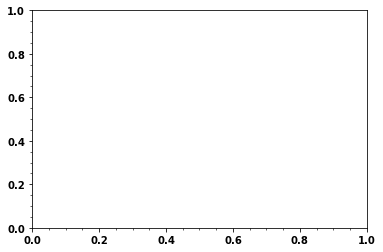

In [1]:
import numpy as np
import numpy as np
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle
import pickle
from tools.constants import NUCLEI_CHARGE, ANALYSIS_RANGE_EKIN, ISOTOPES_MASS, ISOTOPES_COLOR, ISO_LABELS
from tools.constants import DETECTOR_COLOR
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines 
import matplotlib
from tools.MassFunction import expo_func
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.binnings_collection import fbinning_energy, get_bin_center
from tools.calculator import calc_rig_from_ekin
from tools.constants import ISOTOPES_MASS, ISOTOPES_CHARGE
from tools.plottools import xaxistitle, xaxis_binning
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
setplot_defaultstyle()

In [48]:
detectors = ['Tof', 'NaF', 'Agl']
figSize = (22, 15)
isotopes = ["Be7", "Be9", "Be10"]

def get_pull_graph(graph, yfit):
    pull = (graph.yvalues - yfit)/graph.yerrs
    return MGraph(graph.xvalues, pull, np.zeros_like(pull))

#plotdir = '/home/manbing/Documents/Data/data_reso/plots_atdec'
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/plots/plot_resolutions_ekin'

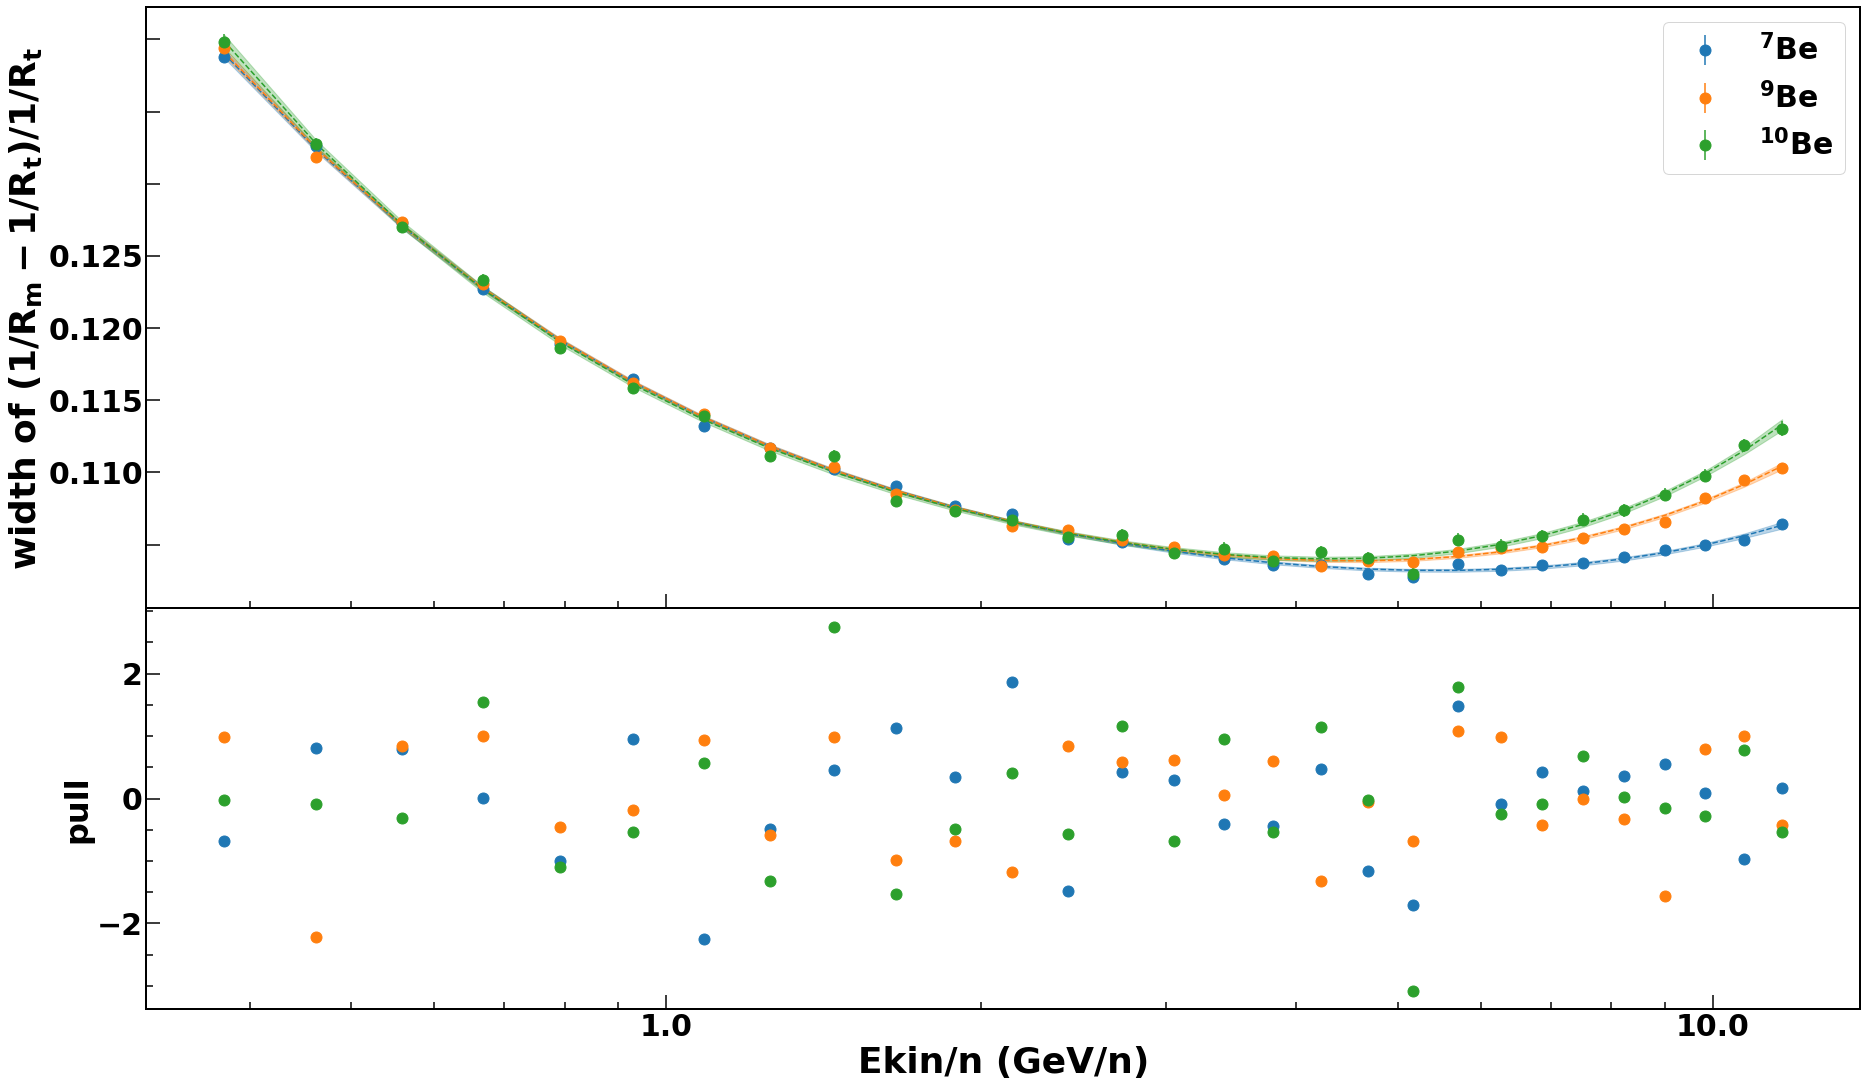

In [18]:
filename_rigreso = '/home/manbing/Documents/lithiumanalysis/scripts/plots/rigfit_vsEkin9/df_reso_sigma.npz'
#filename_rigreso = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/GBLRig/df_reso_sigma.npz'
#plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/rigfit_vsEkin9/'

def get_pull_graph(graph, yfit):
    pull = (graph.yvalues - yfit)/graph.yerrs
    return MGraph(graph.xvalues, pull, np.zeros_like(pull))

isotopes = ['Be7', 'Be9', 'Be10']
df_sigma = np.load(f'{filename_rigreso}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
graph_rigreso_sigma = dict()
dict_polypar = dict()

for iso in isotopes:
    graph_rigreso_sigma[iso] = MGraph.from_file(df_sigma, f"graph_sigma_Tof_{iso}")
    
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(28, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

for iso in isotopes: 
    plot_graph(fig, ax1, graph_rigreso_sigma[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_rigreso_sigma[iso].xvalues 
    popt, pcov = curve_fit(poly, np.log(xval), graph_rigreso_sigma[iso].yvalues, p0 = 1 / (10 ** np.arange(1, 7)), sigma=graph_rigreso_sigma[iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar[iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    graphpull = get_pull_graph(graph_rigreso_sigma[iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    graph_rigreso_sigma[iso].yvalues = yfit
    
graph_ratio_9 = graph_rigreso_sigma['Be9']/graph_rigreso_sigma['Be7']
graph_ratio_10 = graph_rigreso_sigma['Be10']/graph_rigreso_sigma['Be7']
#plot_graph(fig, ax2, graph_ratio_9, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)
#plot_graph(fig, ax2, graph_ratio_10, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS['Be10']}')  
#plot_graph(fig, ax2, graph_ratio_10, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)  

ax2.set_xlabel('Rigidity (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_xscale('log')

ax1.set_ylabel(r'$\mathrm{width~of~(1/R_{m} - 1/R_{t})/1/R_{t}}$')
ax2.set_xlabel('Ekin/n (GeV/n)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])

plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_xscale('log')
ax2.set_ylabel('pull', fontsize=32)
#ax2.set_ylim([-5, 5])
set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax2.set_xticks(np.array([2, 4, 10, 20, 40]))
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotfile, f"rigidity_resolution_vs_ekin_v1", show=True) 

#savefig_tofile(fig, plotfile, f"rigidity_resolution_vs_ekin_v1", show=True) 
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/home/manbing/Documents/lithiumanalysis/slides/plots/plot_resolutions_ekin


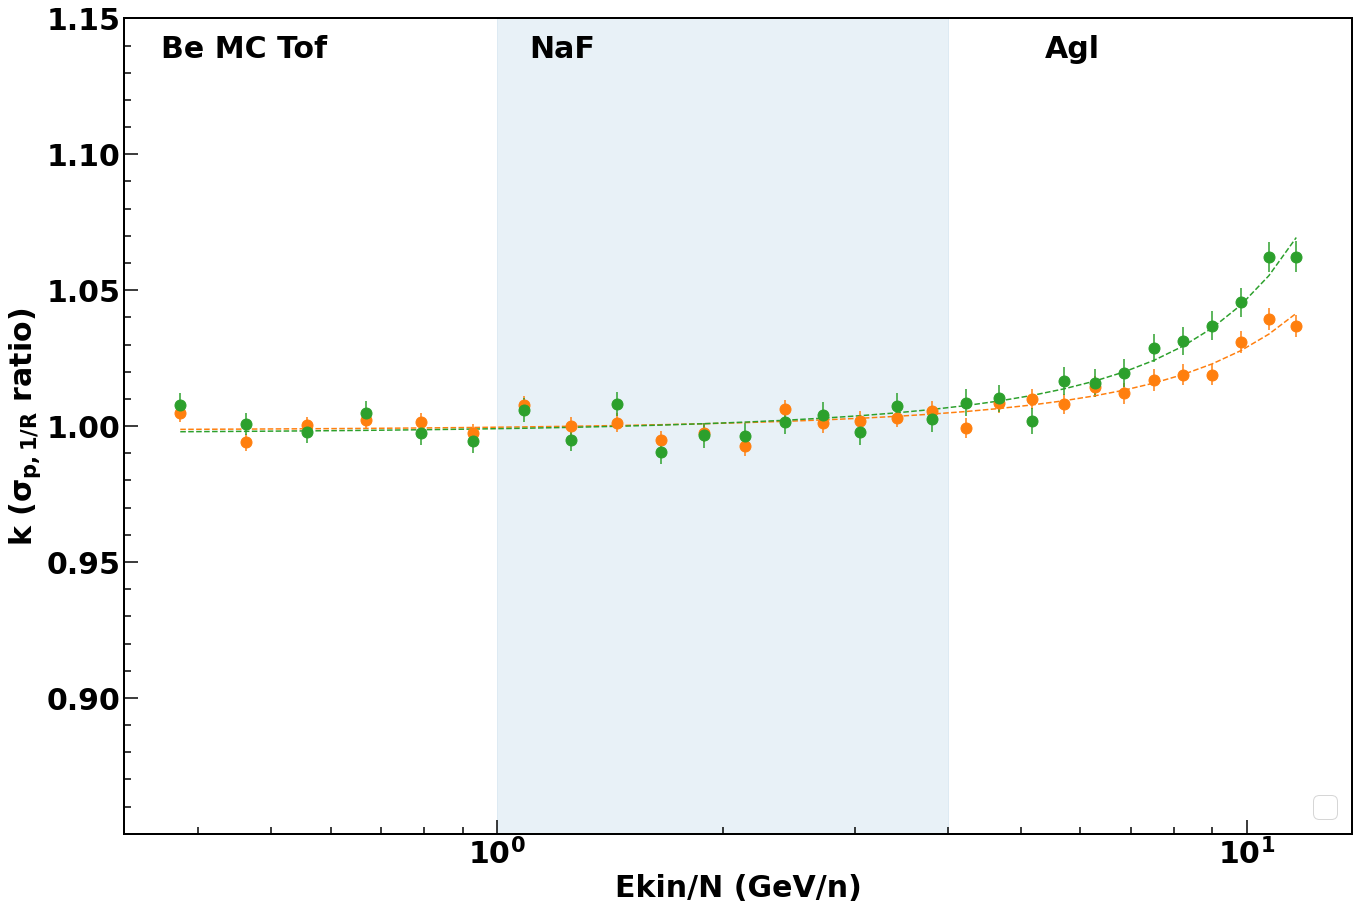

In [19]:
def expo_func(x, pa, pb, pc):                                                                                                                                                                                                                     
    pdf = pa* (1- np.exp((x-pb)/pc))                                                                                                                                                                                                             
    return pdf  

filename_rigreso = '/home/manbing/Documents/lithiumanalysis/scripts/plots/rigfit_vsEkin9/df_rigreso_sigma_ratio.npz'
#plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/sigmap_ratio'
dec_range ={'Tof':[0.3, 1.0], 'NaF':[1.0, 4.0], 'Agl':[4.0, 12.0]}
df_sigma_ratio_rigreso = np.load(f'{filename_rigreso}')
graph_rigreso_sigma_9to7 = dict()
graph_rigreso_sigma_10to7 = dict()
for dec in detectors:
    if dec == 'Tof':
        graph_rigreso_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio_rigreso, f"graph_mass_sigma_9to7_{dec}")
        graph_rigreso_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio_rigreso, f"graph_mass_sigma_10to7_{dec}")
    
#graph_rigreso_sigma_9to7['NaF'] = slice_graph_by_value(graph_rigreso_sigma_9to7['NaF'], [1.2, 3.4])
#graph_rigreso_sigma_9to7_all = concatenate_graphs(graph_rigreso_sigma_9to7['Tof'], graph_rigreso_sigma_9to7['NaF'])
#graph_rigreso_sigma_9to7_all = concatenate_graphs(graph_rigreso_sigma_9to7_all, graph_rigreso_sigma_9to7['Agl'])

#graph_rigreso_sigma_10to7['NaF'] = slice_graph_by_value(graph_rigreso_sigma_10to7['NaF'], [1.2, 3.4])
#graph_rigreso_sigma_10to7_all = concatenate_graphs(graph_rigreso_sigma_10to7['Tof'], graph_rigreso_sigma_10to7['NaF'])
#graph_rigreso_sigma_10to7_all = concatenate_graphs(graph_rigreso_sigma_10to7_all, graph_rigreso_sigma_10to7['Agl'])
graph_rigreso_sigma_10to7_all = graph_rigreso_sigma_10to7['Tof']
graph_rigreso_sigma_9to7_all = graph_rigreso_sigma_9to7['Tof']
splinefit_be9_dec = dict()
splinefit_be10_dec = dict()
fig, ax1 = plt.subplots(1, 1, figsize=figSize) 
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
#plot_graph(fig, ax1,graph_rigreso_sigma_9to7_all , color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label="Be9")
#plot_graph(fig, ax1,graph_rigreso_sigma_10to7_all , color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label="Be10")
for dec in detectors:
    if dec == "Tof":
        plot_graph(fig, ax1, graph_rigreso_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        plot_graph(fig, ax1, graph_rigreso_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
    if dec =="Tof":                                                                                                                                                                                  
        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    else:                                                                                                                                                                                            
        ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")       
ax1.set_ylim([0.85, 1.15])
                                                                                                                                                                        
#ax2.legend(fontsize=20)                                                                                                                                                                          
                                                                                                                                                                        
#ax2.grid()                                                                                                                                                                                       
set_plot_defaultstyle(ax1)                                                                                                                                                                       
#set_plot_defaultstyle(ax2)                                                                                                                                                                       
ax1.get_yticklabels()[0].set_visible(False)                                                                                                                                                      
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
ax1.set_xticklabels([])                                                                                                                                                                          
#ax2.set_xlabel("Ekin/n (GeV/n)") 
ax1.set_xscale('log')
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{k ~ (\sigma_{p, 1/R} ~ ratio)}$')
ax1.fill_betweenx(np.linspace(0.85, 1.15, 100), 1.0, 4.0, alpha=0.1, color="tab:blue")
ax1.legend(loc='lower right')
splinefit_be9 = UnivariateSpline(np.log(graph_rigreso_sigma_9to7_all.xvalues), graph_rigreso_sigma_9to7_all.yvalues, k=3, s=5)

popt9, pcov9 = curve_fit(expo_func, graph_rigreso_sigma_9to7_all.xvalues, 1/graph_rigreso_sigma_9to7_all.yvalues, p0 = [1, 5.0, 10])
y_fit_expo_factor9 = expo_func(graph_rigreso_sigma_9to7_all.xvalues, *popt9)
ax1.plot(graph_rigreso_sigma_9to7_all.xvalues, 1/y_fit_expo_factor9, '--', color='tab:orange')

popt10, pcov10 = curve_fit(expo_func, graph_rigreso_sigma_10to7_all.xvalues, 1/graph_rigreso_sigma_10to7_all.yvalues, p0 = [1, 5.0, 10])
y_fit_expo_factor10 = expo_func(graph_rigreso_sigma_10to7_all.xvalues, *popt10)
ax1.plot(graph_rigreso_sigma_10to7_all.xvalues, 1/y_fit_expo_factor10, '--', color=ISOTOPES_COLOR["Be10"])
#ax1.plot(graph_rigreso_sigma_9to7_all.xvalues, 1/graph_rigreso_sigma_9to7_all.yvalues, '.', color='black', markersize=20)

y_spline = splinefit_be9(np.log(graph_rigreso_sigma_9to7_all.xvalues))
#ax1.plot(graph_rigreso_sigma_9to7_all.xvalues[:], y_spline, '-', color=ISOTOPES_COLOR["Be9"])

splinefit_be10 = UnivariateSpline(np.log(graph_rigreso_sigma_10to7_all.xvalues), graph_rigreso_sigma_10to7_all.yvalues, k=3, s=5)
y_spline = splinefit_be10(np.log(graph_rigreso_sigma_10to7_all.xvalues))

splinedict = {"spline9": splinefit_be9, "spline10": splinefit_be10}
with open('/home/manbing/Documents/lithiumanalysis/scripts/plots/rigfit_vsEkin/spline.pkl', 'wb') as f:
    pickle.dump(splinedict, f)

print(plotdir)
savefig_tofile(fig, plotdir, 'mass_sigmap_korrect_v2', 1)
    

In [20]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23/df_ratio_sigma_iter2.npz'
filename_tof = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v11/df_ratio_sigma_iter2.npz'
#filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v20_s1/df_ratio_sigma_iter2.npz'
df_sigma_ratio = np.load(f'{filename}')
df_sigma_ratio_tof = np.load(f'{filename_tof}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
for dec in detectors:
    if dec == 'Tof':
        graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio_tof, f"graph_mass_sigma_9to7_{dec}")
        graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio_tof, f"graph_mass_sigma_10to7_{dec}")
    else:
        graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_9to7_{dec}")
        graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_10to7_{dec}")

#graph_mass_sigma_9to7['NaF'] = scale_graph(graph_mass_sigma_9to7['NaF'], 0.997)
#graph_mass_sigma_9to7['Agl'] = scale_graph(graph_mass_sigma_9to7['Agl'], 0.997)
#graph_mass_sigma_10to7['NaF'] = scale_graph(graph_mass_sigma_10to7['NaF'], 0.997)
#graph_mass_sigma_10to7['Agl'] = scale_graph(graph_mass_sigma_10to7['Agl'], 0.997)
from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
#plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/sigmakorr'
fig, ax1 = plt.subplots(1, 1, figsize=figSize) 
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
for dec in detectors: 
    if dec =="Tof":
        plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\sigma_{p,be7}/\sigma_{p, be9}}$")
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label="$\mathrm{\sigma_{p,be7}/\sigma_{p, be9}}$")
        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    else:                                                                                                            
        plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")       
ax1.set_ylim([0.6, 0.85])
                                                                                                                                                                        
#ax2.legend(fontsize=20)                                                                                                                                                                          
                                                                                                                                                                        
#ax2.grid()                                                                                                                                                                                       
set_plot_defaultstyle(ax1)                                                                                                                                                                       
                                                                                                                                                                  
ax1.get_yticklabels()[0].set_visible(False)                                                                                                                                                      
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
#ax2.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.6, 0.9, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 

#ax1.axhline(y=7.0/9.0, color='black', linestyle='--')  
ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 
ax1.axhline(y=7.0/10.0, color='green', linestyle='--')  
label_ref9 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be9'], label='m7/m9')  
label_ref10 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be10'], label='m7/m10') 
legend2 = ax1.legend(handles=[label_ref9, label_ref10], loc='upper left', bbox_to_anchor=(0.05, 0.2), fontsize=20)   
ax1.add_artist(legend2)  
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m} ~ ratio}$')

with open('/home/manbing/Documents/lithiumanalysis/scripts/plots/rigfit_vsEkin/spline.pkl', 'rb') as f:
    spline_loaded = pickle.load(f)

#xvalues = np.array([0.37825, 0.4631, 0.559, 0.66835, 0.79125, 0.9303, 1.08555, 1.2571, 1.44745, 1.6566,  1.8872, 2.1419,  2.42075, 2.7237,  3.05343.4126,  3.80125, 4.2221,  4.67795, 5.16875, 5.70575, 6.27195, 6.8673, 7.52005, 8.2303, 8.99805, 9.82325])
xvalues = get_bin_center(fbinning_energy())
sp_kcorr9 = spline_loaded['spline9']
sp_kcorr10 = spline_loaded['spline10']
#expected9 = sp_kcorr9(np.log(xvalues)) * ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9']
#expected10 = sp_kcorr10(np.log(xvalues)) * ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10']


expected9 = 1/y_fit_expo_factor9 * ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9']
expected10 = 1/y_fit_expo_factor10 * ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10']



ax1.plot(xvalues, expected9, "-", color=ISOTOPES_COLOR['Be9'], label="ref k*m7/m9")
ax1.plot(xvalues, expected10, "-", color=ISOTOPES_COLOR['Be10'], label='ref k*m7/m9')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=25)
print(plotdir)
savefig_tofile(fig, plotdir, 'mass_sigmap_ratio_korrection_fromrig', 1)



FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v11/df_ratio_sigma_iter2.npz'

plot gamma

KeyError: 'beta_resolution_Tof_Be9_dimensions is not a file in the archive'

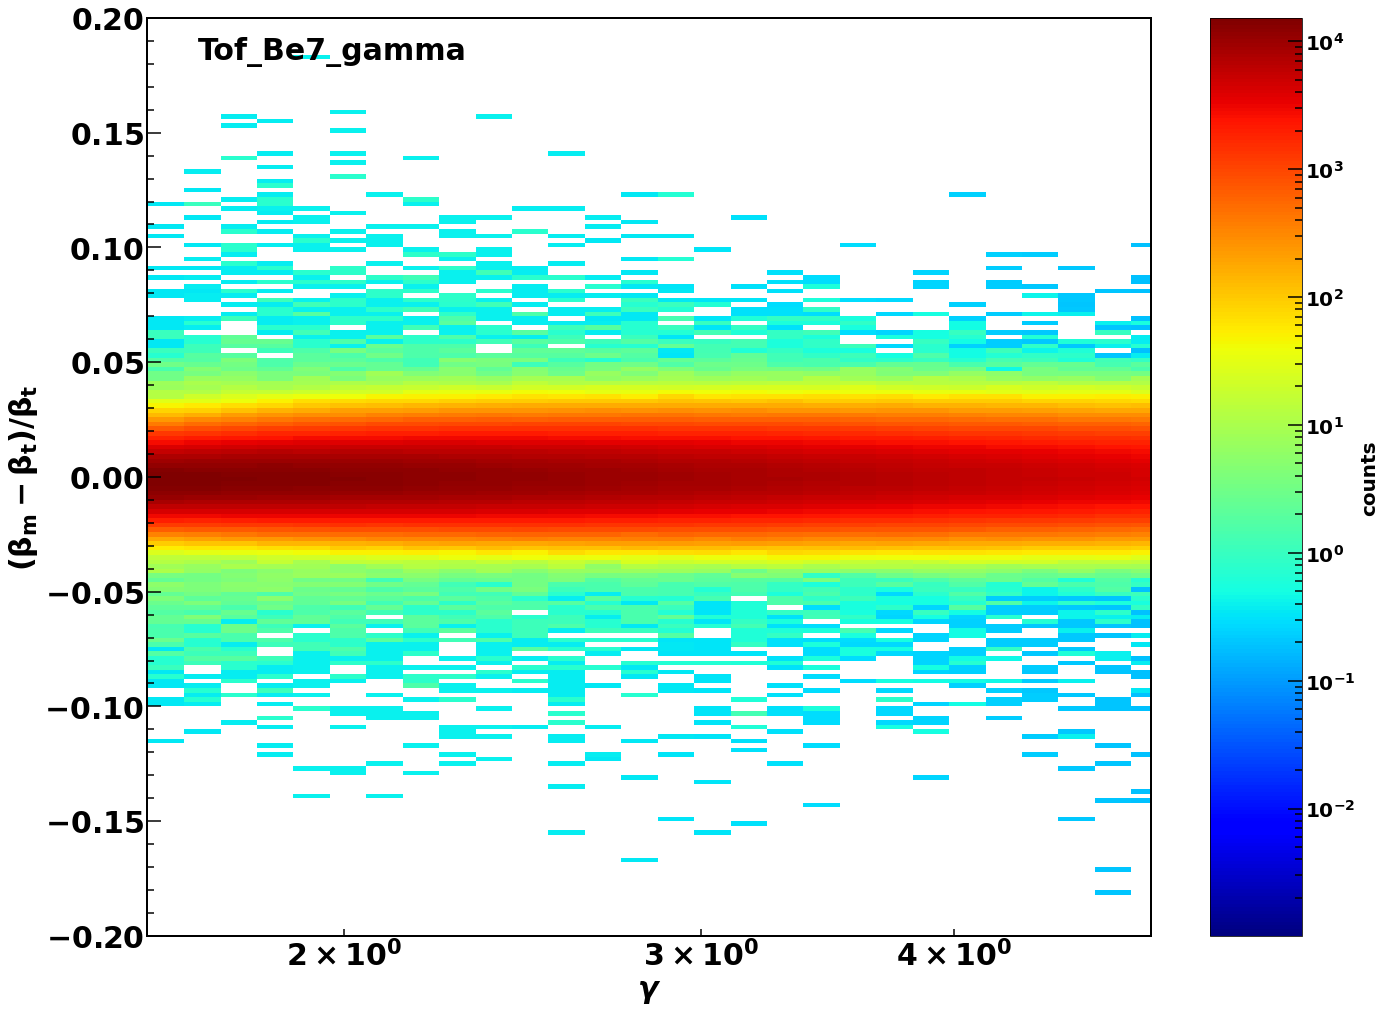

In [21]:
file_beta = '/home/manbing/Documents/Data/data_reso/beta_resolution.npz'
 
hist2d_gamma = {dec: {} for dec in detectors}
gammalim = {'Tof':[1.6, 5.0], "NaF":[2.0, 10.0], "Agl":[3.3, 15.0]}
with np.load(file_beta) as npzfile:
    for dec in detectors:
        for iso in isotopes:
            hist2d_gamma[dec][iso] = WeightedHistogram.from_file(npzfile, f"beta_resolution_{dec}_{iso}")  
            fig = plt.figure(figsize=(20, 15))
            plot = fig.subplots(1, 1) 
            plot2dhist(fig, plot, xbinning=hist2d_gamma[dec][iso].binnings[0].edges[1:-1],
                       ybinning=hist2d_gamma[dec][iso].binnings[1].edges[1:-1],
                       counts=hist2d_gamma[dec][iso].values[1:-1, 1:-1], 
                       xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                       setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=True)  
            plot.text(0.05, 0.98, f"{dec}_{iso}_gamma", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
            plot.set_xlabel(r"$\gamma$", fontsize=30)                                                                                                                                                     
            plot.set_ylabel(r'$\mathrm{(\beta_{m}-\beta_{t})/\beta_{t}}$', fontsize=30)
            plot.set_xscale('log')
            plot.set_xlim(gammalim[dec])
            savefig_tofile(fig, plotdir, f"hist2d_betareso_{dec}_{iso}", show=True)                                                                                                                 

for ibin in range(28):
    hist_ibin_gamma = hist2d_gamma['Agl']['Be7'].project(ibin)
print(hist2d_gamma[dec][iso].binnings[0].edges[1:-1][22])
fig = plt.figure(figsize=(20, 15))
plot = fig.subplots(1, 1) 
plot_histogram_1d(plot, hist_ibin_gamma, style="iss", color="black", label="data", scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False)


In [22]:
mass_gev = 0.9314941

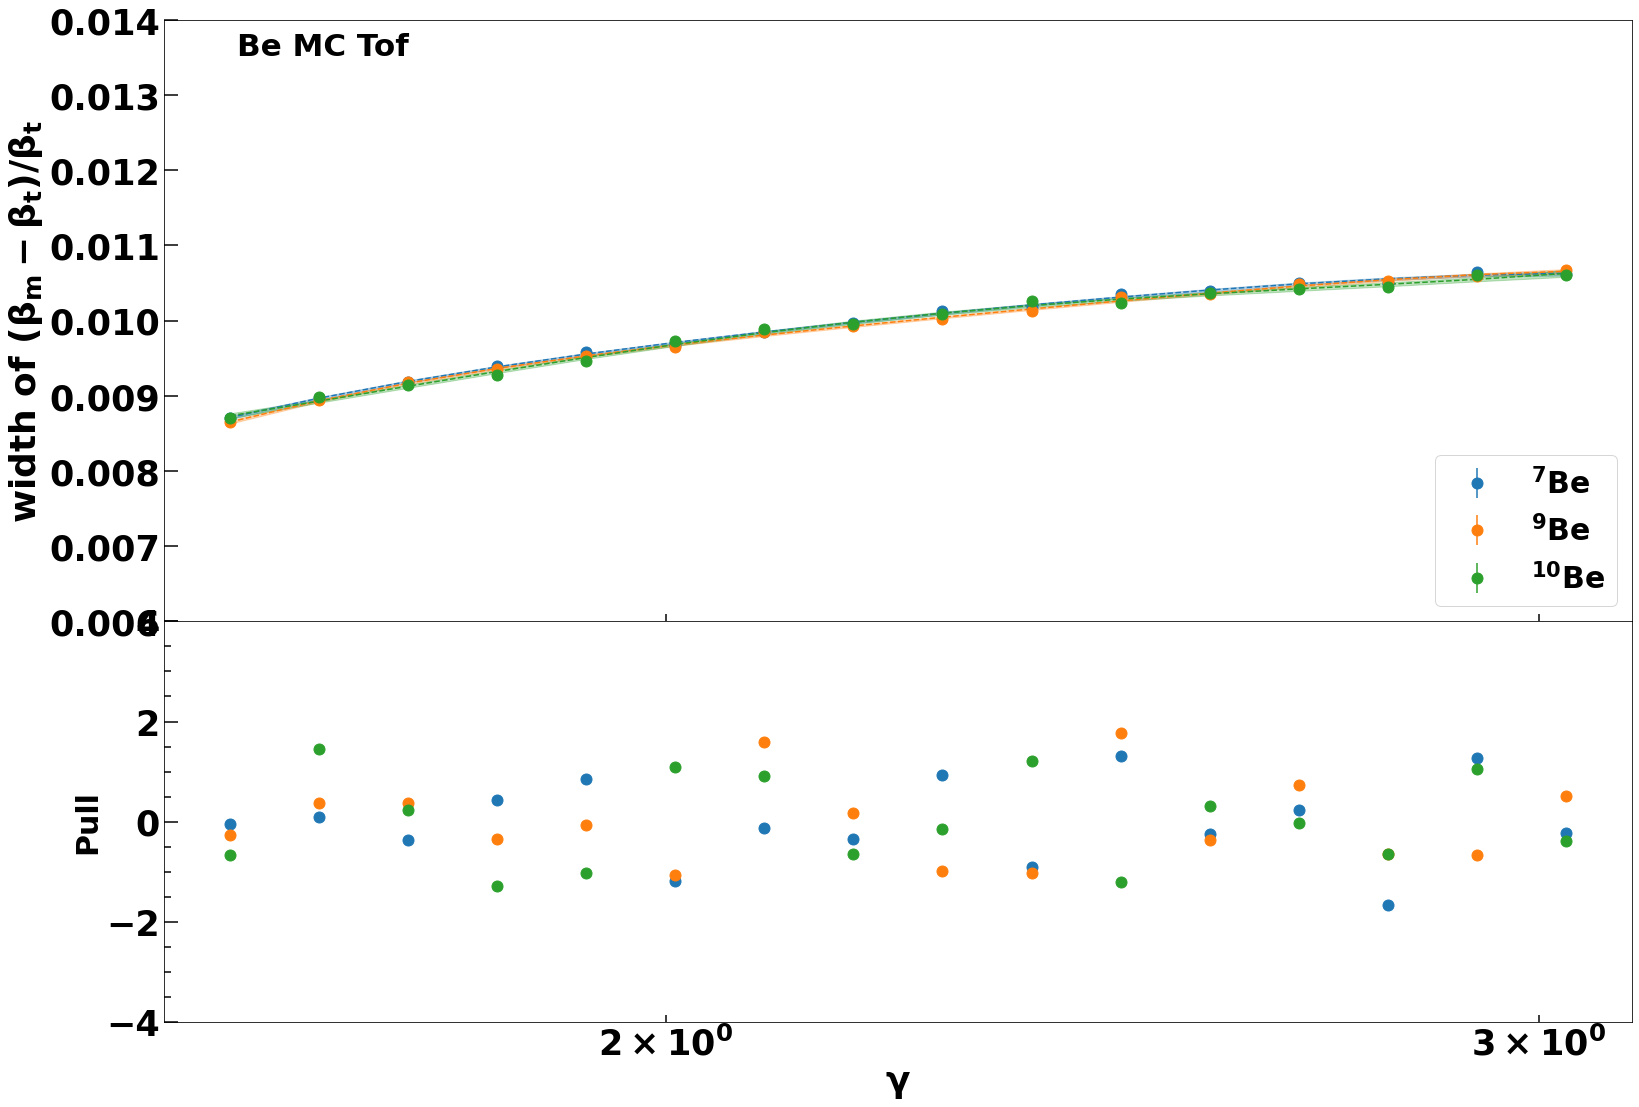

In [23]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/betareso/df_betareso_sigma.npz'
df_sigma = np.load(f'{filename}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
graph_betareso_sigma_Tof = dict()
dict_polypar_Tof = dict()
graph_sigam_timegamma_Tof = dict()
for iso in isotopes:
    graph_betareso_sigma_Tof[iso] = MGraph.from_file(df_sigma, f"graph_sigma_Tof_{iso}")
    graph_sigam_timegamma_Tof[iso] = MGraph(graph_betareso_sigma_Tof[iso].xvalues, graph_betareso_sigma_Tof[iso].xvalues**2 * graph_betareso_sigma_Tof[iso].yvalues, graph_betareso_sigma_Tof[iso].xvalues**2 *graph_betareso_sigma_Tof[iso].yerrs)

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

for iso in isotopes: 
    plot_graph(fig, ax1, graph_betareso_sigma_Tof[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_betareso_sigma_Tof[iso].xvalues 
    popt, pcov = curve_fit(poly, np.log(xval), graph_betareso_sigma_Tof[iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_betareso_sigma_Tof[iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_Tof[iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    graphpull = get_pull_graph(graph_betareso_sigma_Tof[iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  

ax1.text(0.05, 0.98, "Be MC Tof", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ratio9to7_Tof = graph_betareso_sigma_Tof['Be9']/graph_betareso_sigma_Tof['Be7']
ratio10to7_Tof = graph_betareso_sigma_Tof['Be10']/graph_betareso_sigma_Tof['Be7']

#plot_graph(fig, ax2, ratio9to7_Tof, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, ratio10to7_Tof, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{width~of~(\beta_{m} - \beta_{t})/\beta_{t}}$')
ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
#ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylim([0.006, 0.014])
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
savefig_tofile(fig, plotdir, f"beta_resolution_vs_gamma_Tof", show=True) 


FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410/betaterm_vs_gamma_Tof1.png'

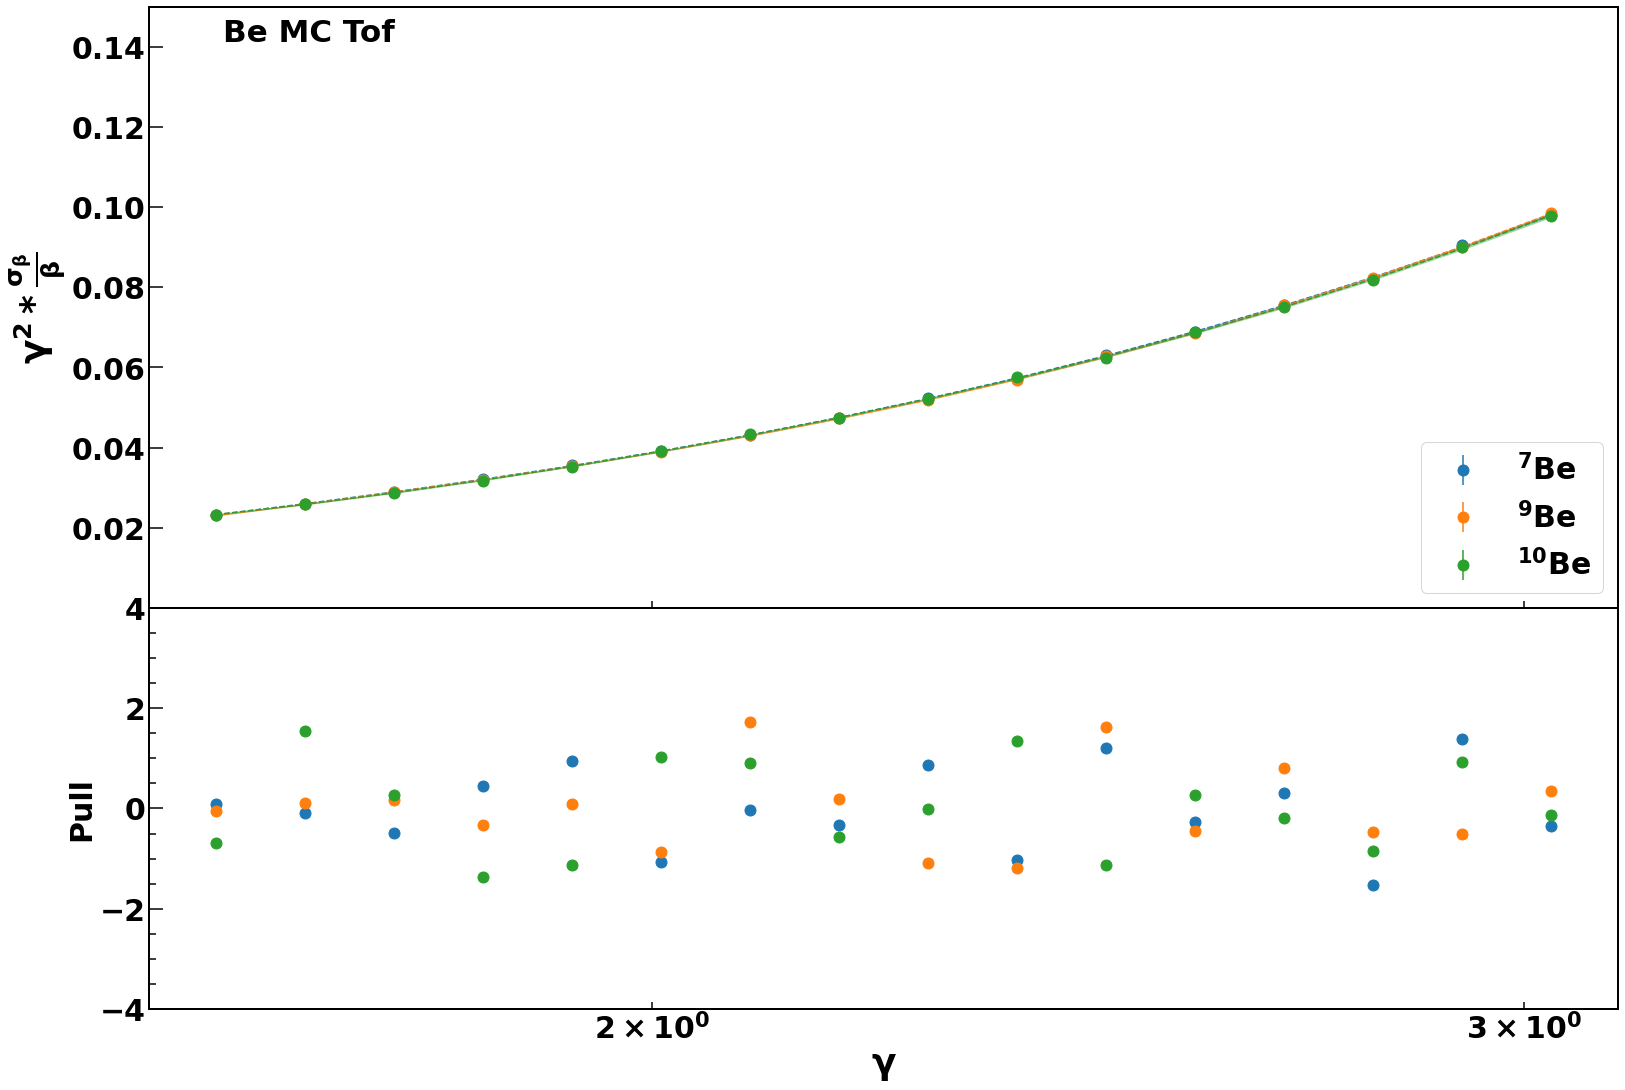

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
dict_polypar_beta_Tof = dict()
for iso in isotopes: 
    plot_graph(fig, ax1, graph_sigam_timegamma_Tof[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_sigam_timegamma_Tof[iso].xvalues 
    popt, pcov = curve_fit(poly, np.log(xval), graph_sigam_timegamma_Tof[iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_sigam_timegamma_Tof[iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_beta_Tof[iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    graphpull = get_pull_graph(graph_sigam_timegamma_Tof[iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  

betagamma_ratio9to7 = graph_sigam_timegamma_Tof['Be9']/graph_sigam_timegamma_Tof['Be7']
betagamma_ratio10to7 = graph_sigam_timegamma_Tof['Be10']/graph_sigam_timegamma_Tof['Be7']
#plot_graph(fig, ax2, betagamma_ratio9to7, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, betagamma_ratio10to7, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')
ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.text(0.05, 0.98, "Be MC Tof", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")

ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
ax1.set_ylim([0.0, 0.15])
ax1.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
savefig_tofile(fig, plotfile, f"betaterm_vs_gamma_Tof1", show=True) 
#ax1.set_ylim([0.008, 0.011])

[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535
  9.83559005 10.65980353 11.54569213 12.49325583 13.50244097]
[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535
  9.83559005 10.65980353 11.54569213 12.49325583 13.50244097]
[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535


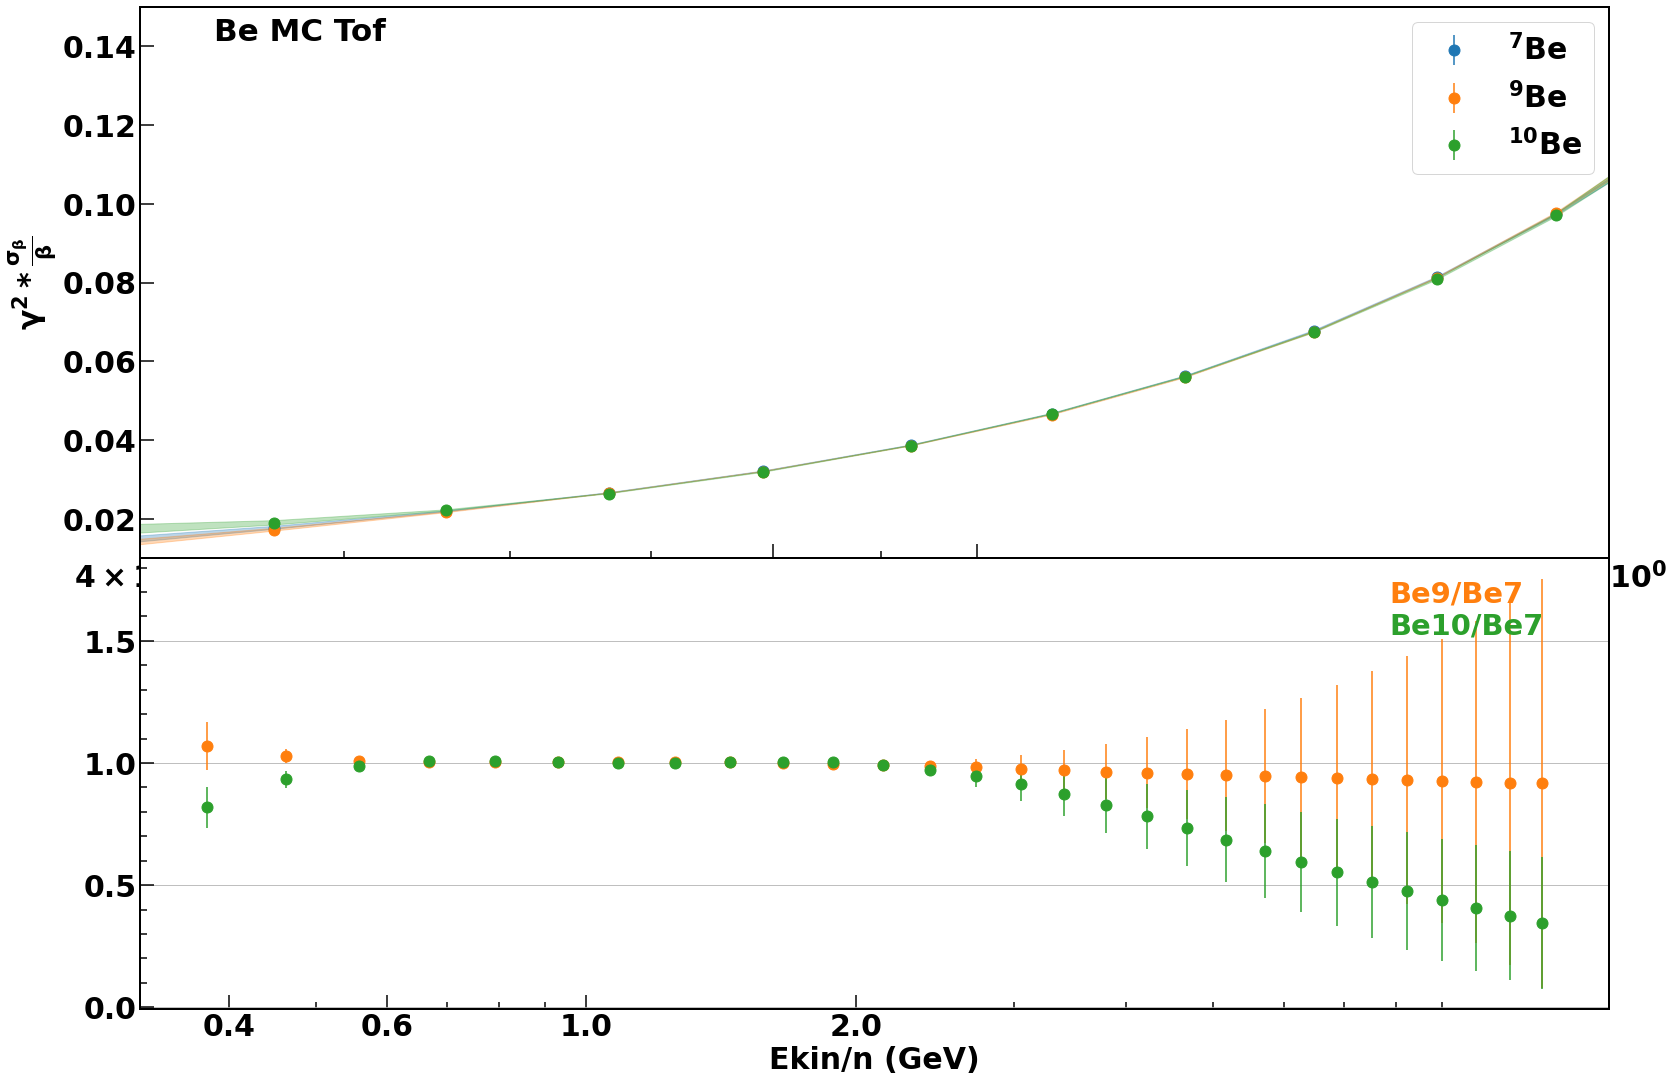

In [25]:
from tools.constants import MASS_NUCLEON_GEV
def calc_gamma_from_ekin(ekin):                                                                                                                                                                          
    gamma = ekin/MASS_NUCLEON_GEV + 1.0                                                                                                                                                                  
    return gamma  

x_ekin = get_bin_center(fbinning_energy())

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
graph_betaterm_vs_ekin_Tof = dict()
for iso in isotopes:
    xval_gamma = calc_gamma_from_ekin(x_ekin)
    print(xval_gamma)
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval_gamma), dict_polypar_beta_Tof[iso], upoly)
    #ax1.plot(x_ekin, yfit, "--",  color=ISOTOPES_COLOR[iso], label=f'{ISO_LABELS[iso]}')
    graph_betaterm_vs_ekin_Tof[iso] = MGraph(x_ekin, yfit, yfit_err)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval_gamma), dict_polypar_beta_Tof[iso], upoly)
    ax1.fill_between(x_ekin, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    plot_graph(fig, ax1, graph_betaterm_vs_ekin_Tof[iso] , color=ISOTOPES_COLOR[iso],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
graph_ratio_9 = graph_betaterm_vs_ekin_Tof['Be7']/graph_betaterm_vs_ekin_Tof['Be9']
graph_ratio_10 = graph_betaterm_vs_ekin_Tof['Be7']/graph_betaterm_vs_ekin_Tof['Be10']
plot_graph(fig, ax2, graph_ratio_9, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
plot_graph(fig, ax2, graph_ratio_10, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)  
ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')                                            
ax2.set_xlabel('Ekin/n (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
#ax1.set_xticks([0.8, 1.0])
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_xscale('log')
ax1.set_ylim([0.01, 0.15])
ax1.set_xlim([0.4, 2.0])
ax2.grid(axis='y')

plt.subplots_adjust(hspace=.0)   
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([0.4, 0.6, 1.0, 2.0]))

ax1.set_xticks(np.array([0.8, 1.0]))
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax1.get_xticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
ax2.text(0.85, 0.95, "Be9/Be7", fontsize=FONTSIZE-1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be9'])
ax2.text(0.85, 0.88, "Be10/Be7", fontsize=FONTSIZE-1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be10'])
ax1.text(0.05, 0.98, "Be MC Tof", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
print(plotdir)
savefig_tofile(fig, plotdir, f"betaterm_vs_ekin_Tof", show=True) 


[2.1822465  2.27437779 2.37039873 2.47047354 2.57477336 2.68347656
 2.79676906 2.91484461 3.03790513 3.16616109 3.29983183 3.43914596
 3.58434172 3.73566745 3.89338192 4.05775488]
[2.1822465  2.27437779 2.37039873 2.47047354 2.57477336 2.68347656
 2.79676906 2.91484461 3.03790513 3.16616109 3.29983183 3.43914596
 3.58434172 3.73566745 3.89338192 4.05775488]
[2.1822465  2.27437779 2.37039873 2.47047354 2.57477336 2.68347656
 2.79676906 2.91484461 3.03790513 3.16616109 3.29983183 3.43914596
 3.58434172 3.73566745 3.89338192 4.05775488]
/home/manbing/Documents/lithiumanalysis/slides/plots/plot_resolutions_ekin


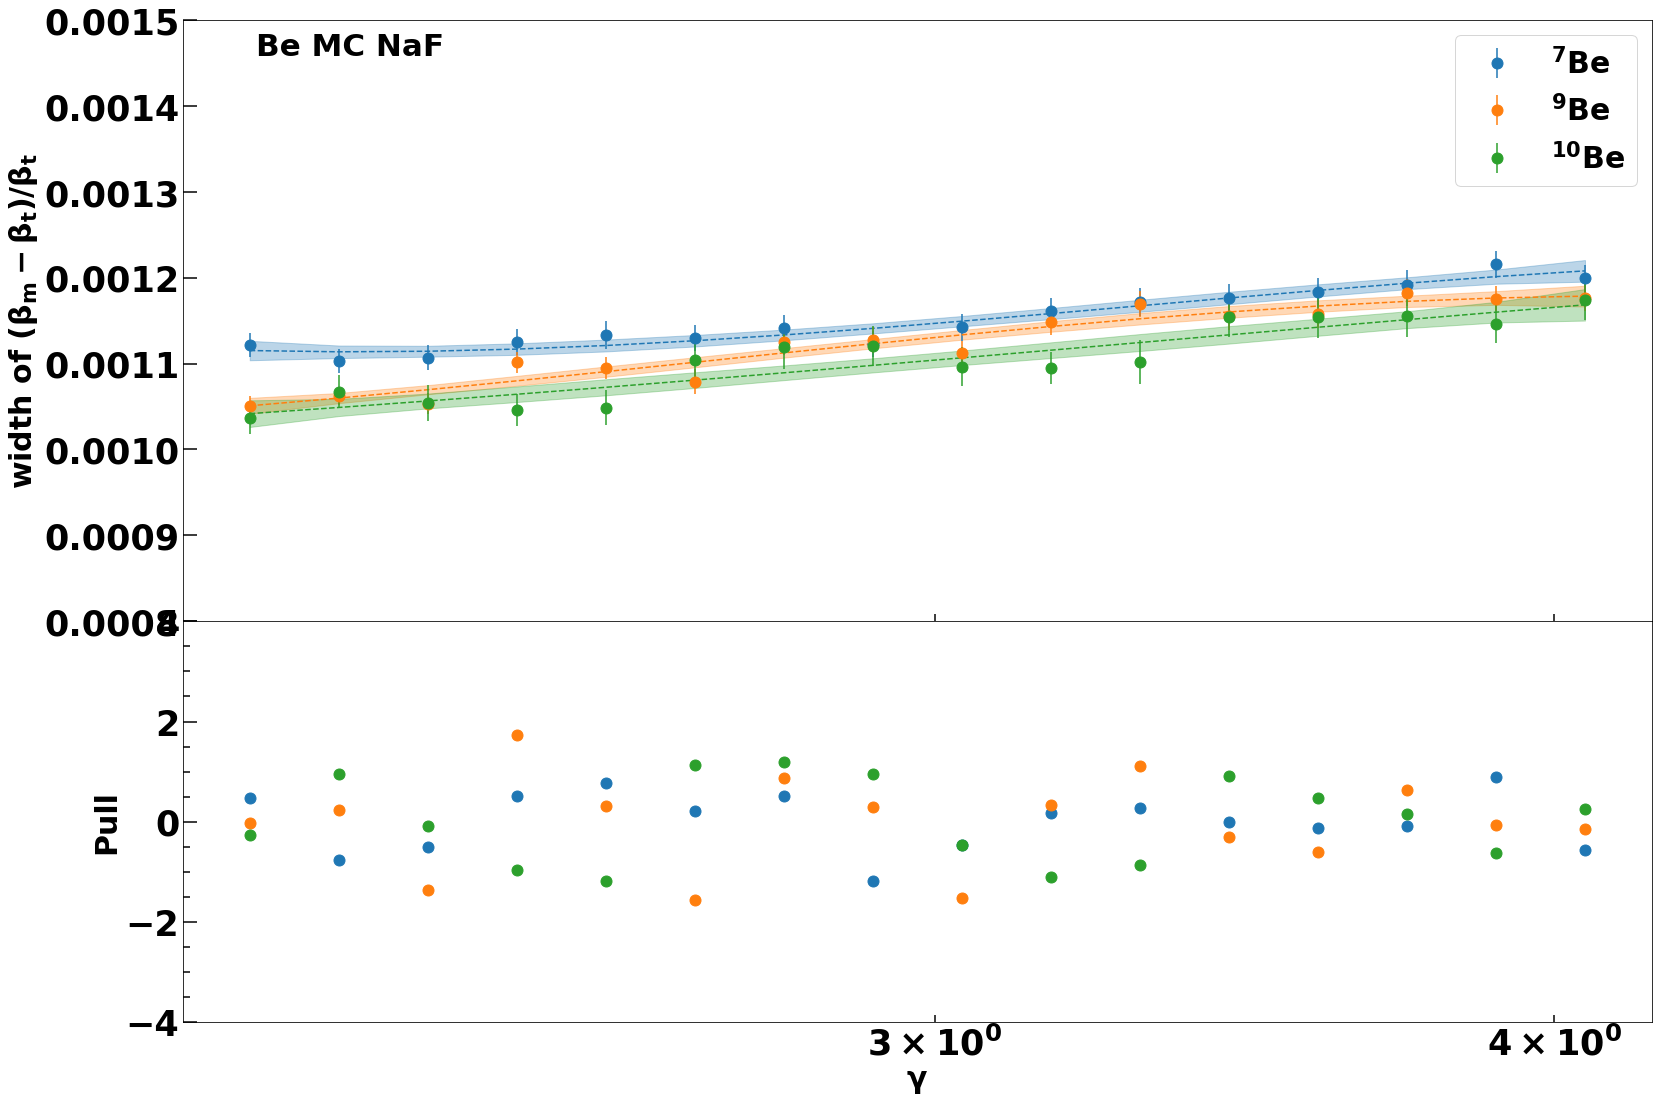

In [26]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/betareso/df_betareso_sigma.npz'
df_sigma = np.load(f'{filename}')

graph_betasigma_NaF = dict()
dict_polypar_NaF = dict()
graph_sigam_timegamma_NaF = dict()
for iso in isotopes:
    graph_betasigma_NaF[iso] = MGraph.from_file(df_sigma, f"graph_sigma_NaF_{iso}")
    graph_sigam_timegamma_NaF[iso] = MGraph(graph_betasigma_NaF[iso].xvalues, graph_betasigma_NaF[iso].xvalues**2 * graph_betasigma_NaF[iso].yvalues, graph_betasigma_NaF[iso].xvalues**2 *graph_betasigma_NaF[iso].yerrs)
    print(graph_betasigma_NaF[iso].xvalues)
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

for iso in isotopes: 
    plot_graph(fig, ax1, graph_betasigma_NaF[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_betasigma_NaF[iso].xvalues 
    popt, pcov = curve_fit(poly, np.log(xval), graph_betasigma_NaF[iso].yvalues, p0 = 1 / (10 ** np.arange(1, 5)), sigma=graph_betasigma_NaF[iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_NaF[iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    graphpull = get_pull_graph(graph_betasigma_NaF[iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  

ax1.text(0.05, 0.98, "Be MC NaF", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ratio9to7 = graph_betasigma_NaF['Be9']/graph_betasigma_NaF['Be7']
ratio10to7 = graph_betasigma_NaF['Be10']/graph_betasigma_NaF['Be7']
#plot_graph(fig, ax2, ratio9to7, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, ratio10to7, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{width~of~(\beta_{m} - \beta_{t})/\beta_{t}}$') 
ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
#ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylim([0.0008, 0.0015])
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
#ax1.set_ylim([0.0005, 0.001])
print(plotdir)
savefig_tofile(fig, plotdir, f"beta_resolution_vs_gamma_NaF", show=True) 

[2.1822465  2.27437779 2.37039873 2.47047354 2.57477336 2.68347656
 2.79676906 2.91484461 3.03790513 3.16616109 3.29983183 3.43914596
 3.58434172 3.73566745 3.89338192 4.05775488]
[2.1822465  2.27437779 2.37039873 2.47047354 2.57477336 2.68347656
 2.79676906 2.91484461 3.03790513 3.16616109 3.29983183 3.43914596
 3.58434172 3.73566745 3.89338192 4.05775488]
[2.1822465  2.27437779 2.37039873 2.47047354 2.57477336 2.68347656
 2.79676906 2.91484461 3.03790513 3.16616109 3.29983183 3.43914596
 3.58434172 3.73566745 3.89338192 4.05775488]
/home/manbing/Documents/lithiumanalysis/slides/plots/plot_resolutions_ekin


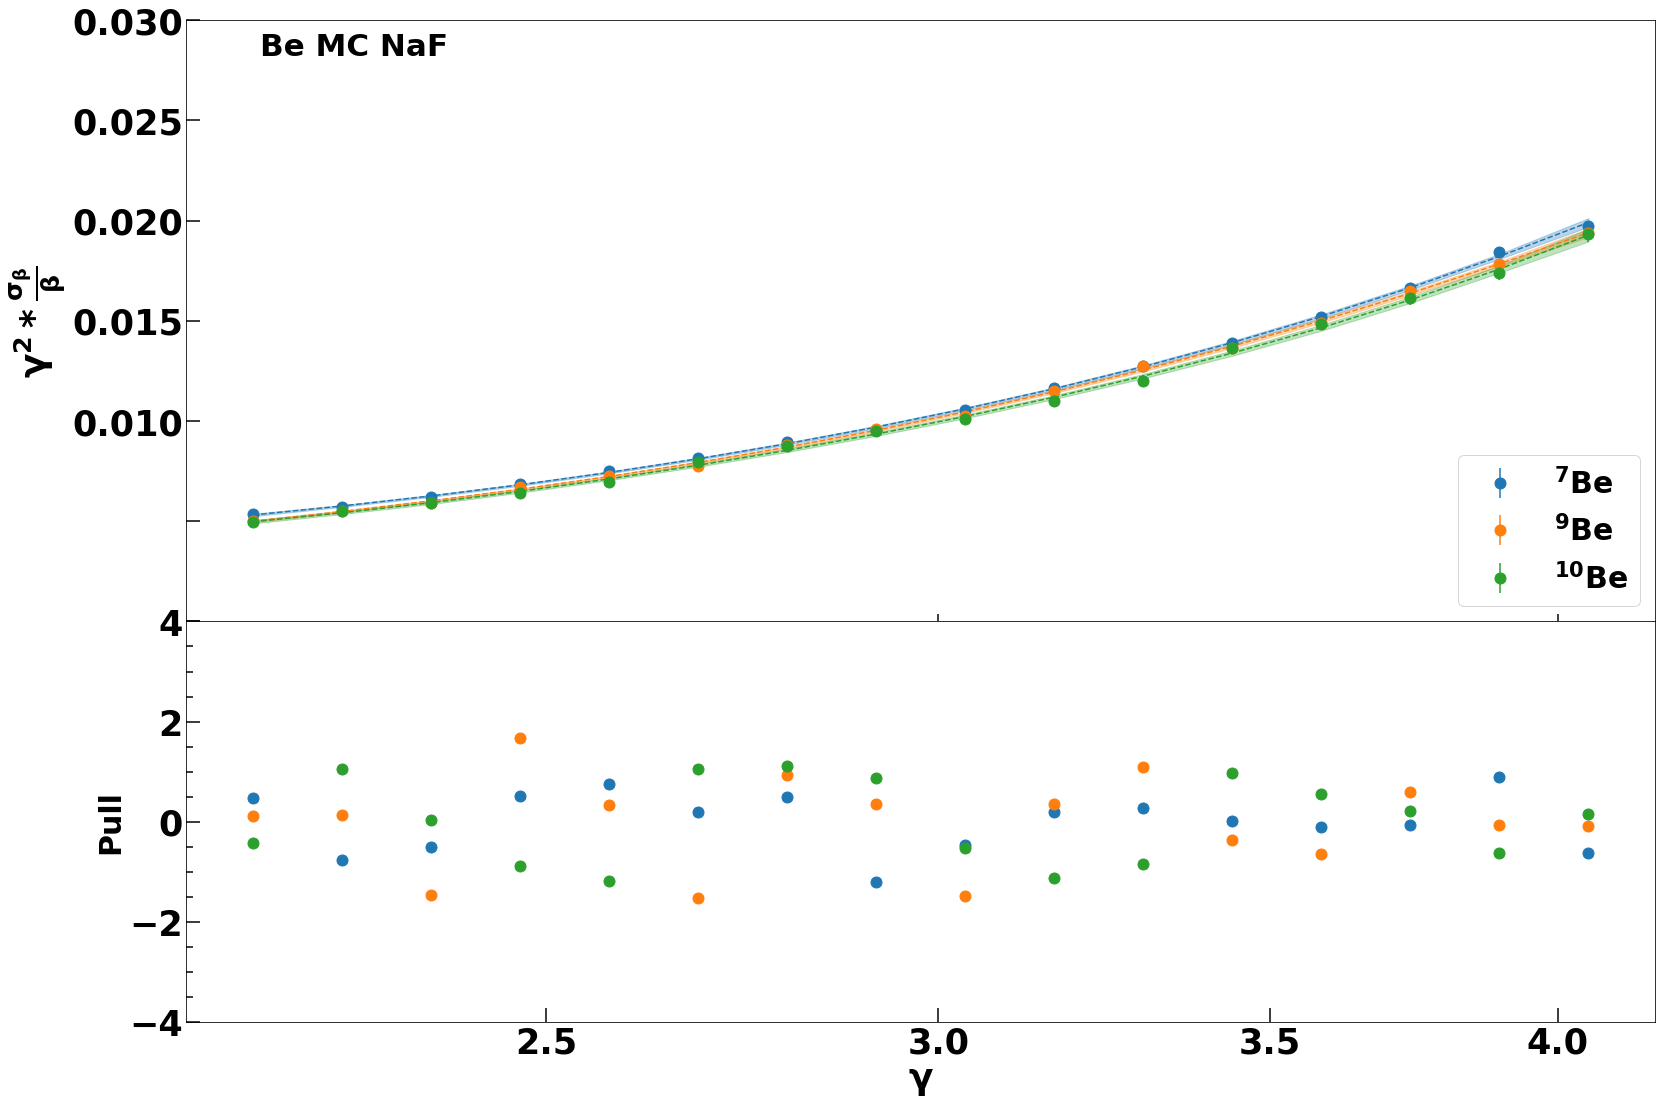

In [27]:

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
dict_polypar_beta_NaF = dict()
for iso in isotopes: 
    plot_graph(fig, ax1, graph_sigam_timegamma_NaF[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_sigam_timegamma_NaF[iso].xvalues 
    print(xval)
    popt, pcov = curve_fit(poly, np.log(xval), graph_sigam_timegamma_NaF[iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_sigam_timegamma_NaF[iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_beta_NaF[iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    graphpull = get_pull_graph(graph_sigam_timegamma_NaF[iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
betagamma_ratio9to7 = graph_sigam_timegamma_NaF['Be9']/graph_sigam_timegamma_NaF['Be7']
betagamma_ratio10to7 = graph_sigam_timegamma_NaF['Be10']/graph_sigam_timegamma_NaF['Be7']
#plot_graph(fig, ax2, betagamma_ratio9to7, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, betagamma_ratio10to7, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')
ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
ax1.set_ylim([0.0, 0.03])
ax1.get_yticklabels()[0].set_visible(False)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([2.5, 3.0, 3.5, 4.0]))
ax1.text(0.05, 0.98, "Be MC NaF", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotfile, f"betaterm_vs_gamma_NaF1", show=True) 
print(plotdir)
#ax1.set_ylim([0.008, 0.011])

[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535
  9.83559005 10.65980353 11.54569213 12.49325583 13.50244097]
[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535
  9.83559005 10.65980353 11.54569213 12.49325583 13.50244097]
[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535


Text(0.05, 0.98, 'Be MC NaF')

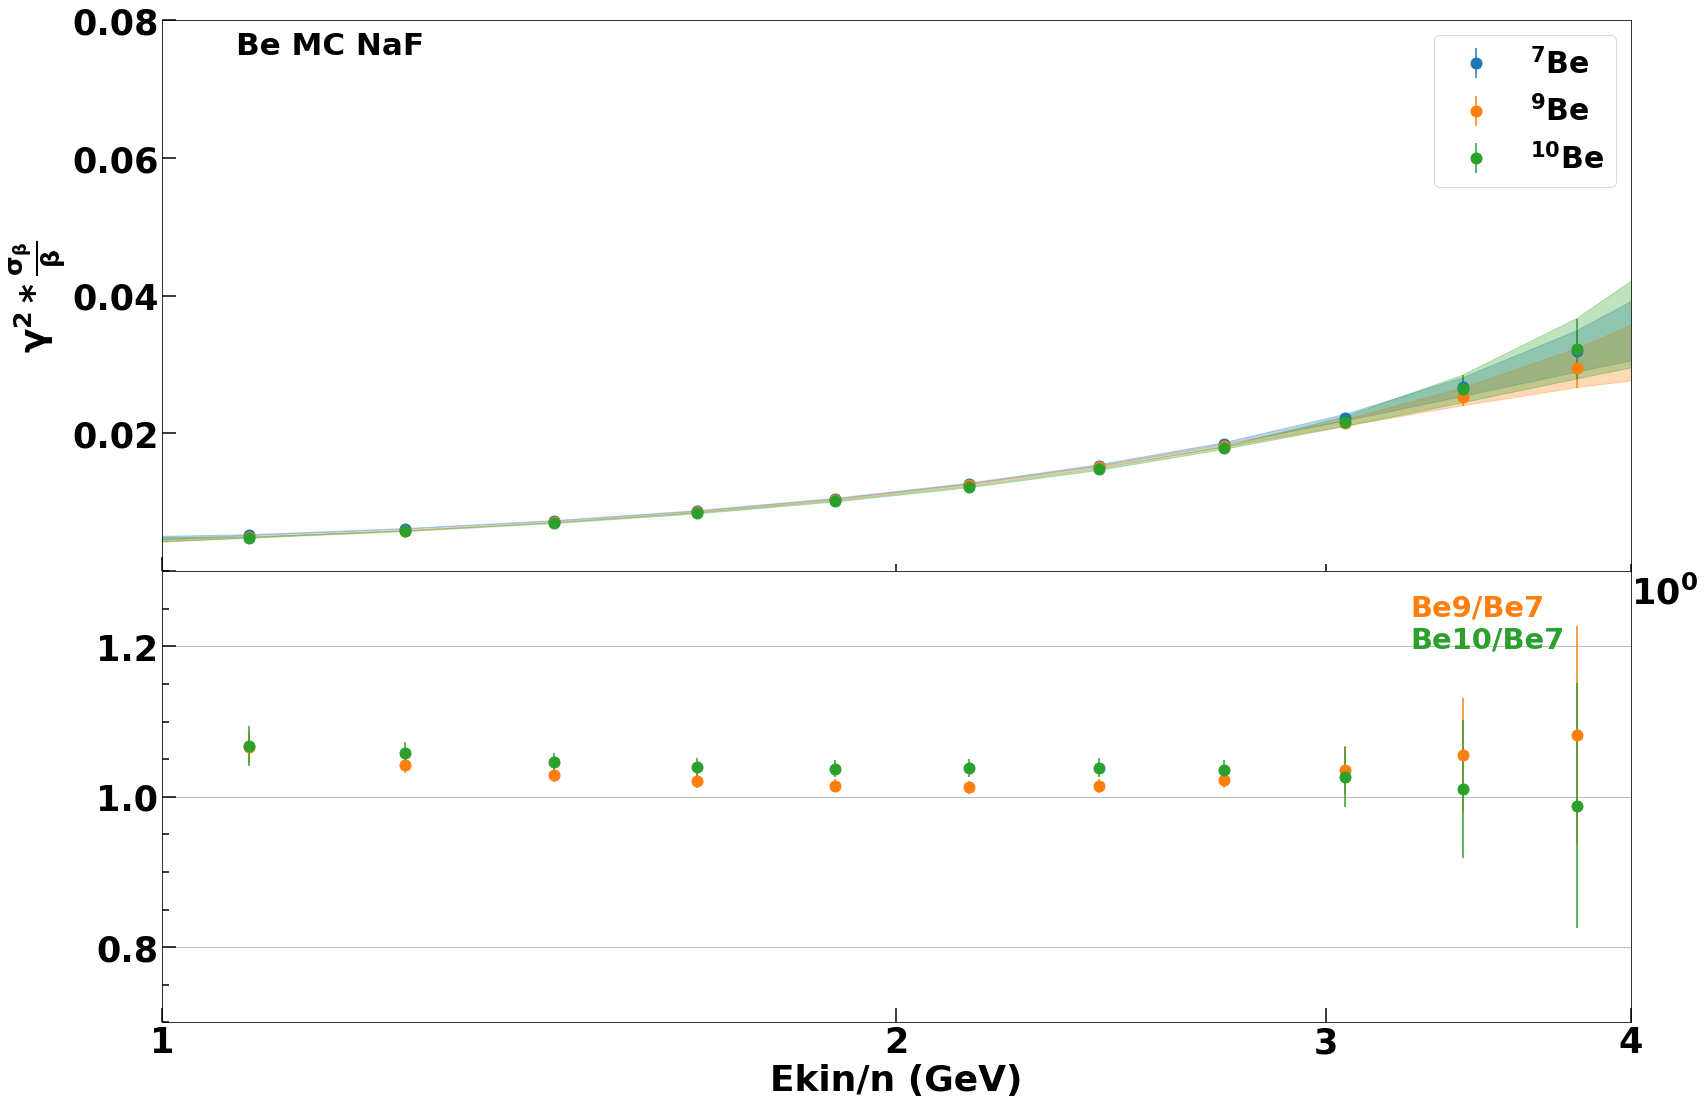

In [28]:
from tools.constants import MASS_NUCLEON_GEV

def calc_gamma_from_ekin(ekin):                                                                                                                                                                          
    gamma = ekin/MASS_NUCLEON_GEV + 1.0                                                                                                                                                                  
    return gamma  

x_ekin = get_bin_center(fbinning_energy())

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
graph_betaterm_vs_ekin_NaF = dict()
for iso in isotopes:
    xval_gamma = calc_gamma_from_ekin(x_ekin)
    print(xval_gamma)
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval_gamma), dict_polypar_beta_NaF[iso], upoly)
    #ax1.plot(x_ekin, yfit, "--",  color=ISOTOPES_COLOR[iso], label=f'{ISO_LABELS[iso]}')
    graph_betaterm_vs_ekin_NaF[iso] = MGraph(x_ekin, yfit, yfit_err)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval_gamma), dict_polypar_beta_NaF[iso], upoly)
    ax1.fill_between(x_ekin, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    plot_graph(fig, ax1, graph_betaterm_vs_ekin_NaF[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
    
graph_ratio_9 = graph_betaterm_vs_ekin_NaF['Be7']/graph_betaterm_vs_ekin_NaF['Be9']
graph_ratio_10 = graph_betaterm_vs_ekin_NaF['Be7']/graph_betaterm_vs_ekin_NaF['Be10']
plot_graph(fig, ax2, graph_ratio_9, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
plot_graph(fig, ax2, graph_ratio_10, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)  
ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')                                            
ax2.set_xlabel('Ekin/n (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylim([0.0, 0.08])
ax2.set_ylim([0.7, 1.3])
ax1.set_xlim([1.0, 4.0])
ax2.set_xlim([1.0, 4.0])
ax2.grid(axis='y')

plt.subplots_adjust(hspace=.0)   
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([1, 2, 3, 4]))
ax2.text(0.85, 0.95, "Be9/Be7", fontsize=FONTSIZE-1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be9'])
ax2.text(0.85, 0.88, "Be10/Be7", fontsize=FONTSIZE-1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be10'])
ax1.text(0.05, 0.98, "Be MC NaF", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")

#savefig_tofile(fig, plotdir, f"betaterm_vs_ekin_NaF", show=True) 


[ 3.73566745  3.89338192  4.05775488  4.22906742  4.40761253  4.59369555
  4.78763473  4.98976175  5.20042227  5.41997657  5.64880014  5.88728432
  6.13583694  6.3948831   6.66486582  6.94624681  7.2395073   7.54514883
  7.8636941   8.19568789  8.54169798  8.90231611  9.27815902  9.66986947
 10.07811737 10.50360091 10.94704775 11.40921627 11.89089688 12.39291334
 12.91612422 13.4614243  14.02974616 14.62206175 15.23938405]
[ 3.73566745  3.89338192  4.05775488  4.22906742  4.40761253  4.59369555
  4.78763473  4.98976175  5.20042227  5.41997657  5.64880014  5.88728432
  6.13583694  6.3948831   6.66486582  6.94624681  7.2395073   7.54514883
  7.8636941   8.19568789  8.54169798  8.90231611  9.27815902  9.66986947
 10.07811737 10.50360091 10.94704775 11.40921627 11.89089688 12.39291334
 12.91612422 13.4614243  14.02974616 14.62206175 15.23938405]
[ 3.73566745  3.89338192  4.05775488  4.22906742  4.40761253  4.59369555
  4.78763473  4.98976175  5.20042227  5.41997657  5.64880014  5.88728432


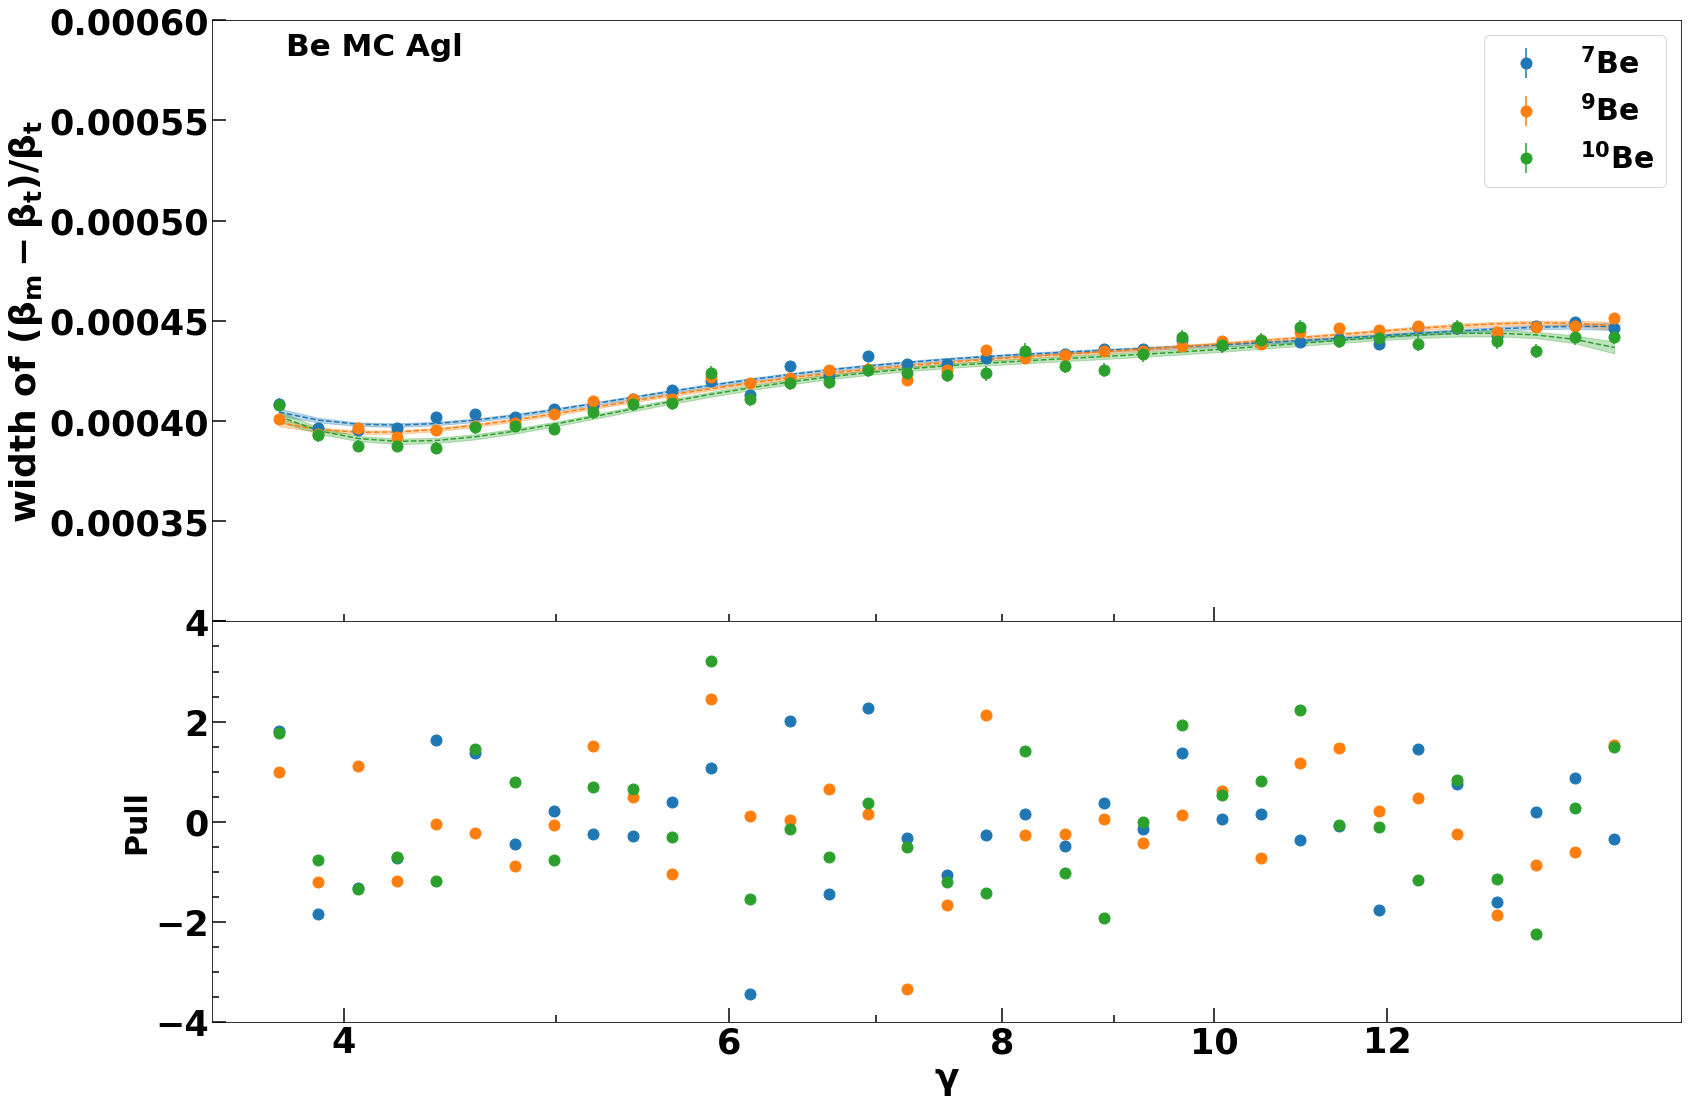

In [29]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/betareso/df_betareso_sigma.npz'
df_sigma = np.load(f'{filename}')

graph_betasigma_Agl = dict()
dict_polypar_Agl = dict()
graph_sigam_timegamma_Agl = dict()
for iso in isotopes:
    graph_betasigma_Agl[iso] = MGraph.from_file(df_sigma, f"graph_sigma_Agl_{iso}")
    graph_sigam_timegamma_Agl[iso] = MGraph(graph_betasigma_Agl[iso].xvalues, graph_betasigma_Agl[iso].xvalues**2 * graph_betasigma_Agl[iso].yvalues, graph_betasigma_Agl[iso].xvalues**2 *graph_betasigma_Agl[iso].yerrs)

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

for iso in isotopes: 
    plot_graph(fig, ax1, graph_betasigma_Agl[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_betasigma_Agl[iso].xvalues 
    print(xval)
    popt, pcov = curve_fit(poly, np.log(xval), graph_betasigma_Agl[iso].yvalues, p0 = 1 / (10 ** np.arange(1, 7)), sigma=graph_betasigma_Agl[iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_Agl[iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    graphpull = get_pull_graph(graph_betasigma_Agl[iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
ratio9to7 = graph_betasigma_Agl['Be9']/graph_betasigma_Agl['Be7']
ratio10to7 = graph_betasigma_Agl['Be10']/graph_betasigma_Agl['Be7']
#plot_graph(fig, ax2, ratio9to7, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, ratio10to7, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{width~of~(\beta_{m} - \beta_{t})/\beta_{t}}$')
ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
#ax1.set_ylim([0.0005, 0.001])
ax1.set_ylim([0.0003, 0.0006])
ax2.set_ylim([-4, 4])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([4, 6, 8, 10, 12]))
ax1.text(0.05, 0.98, "Be MC Agl", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
print(plotdir)
#savefig_tofile(fig, plotdir, f"beta_resolution_vs_gamma_Agl", show=True) 


/home/manbing/Documents/lithiumanalysis/slides/plots/plot_resolutions_ekin


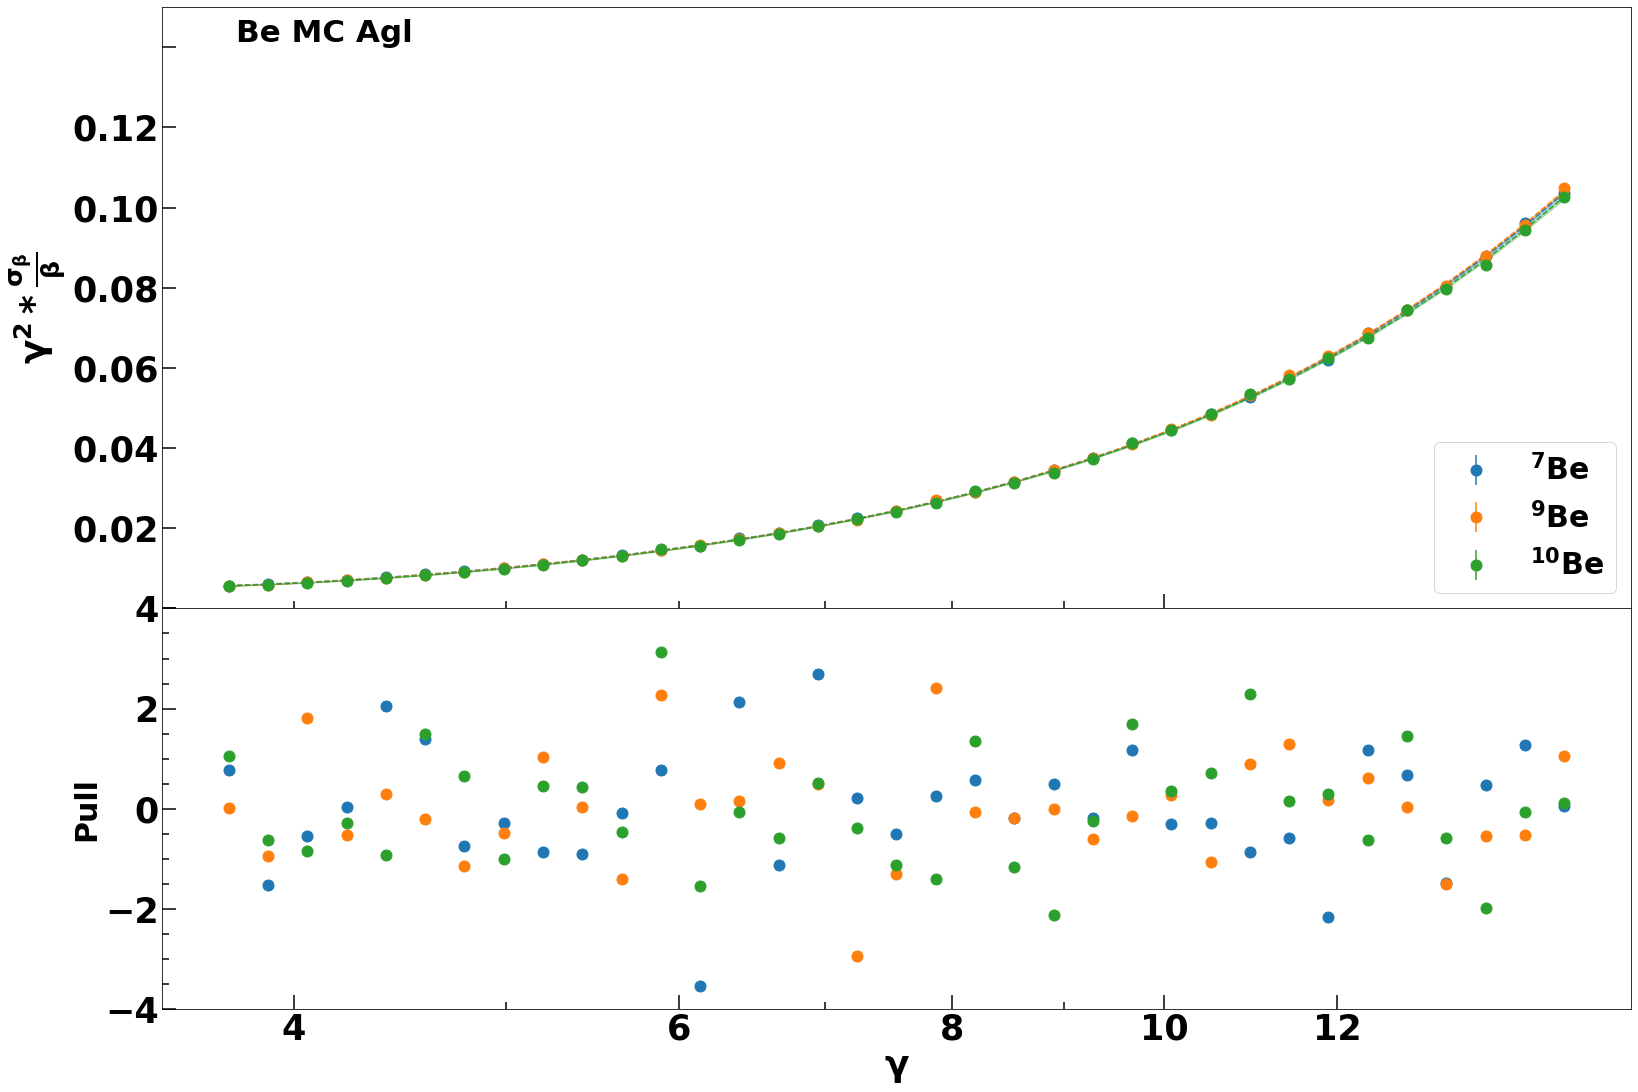

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
dict_polypar_beta_Agl = dict()
for iso in isotopes: 
    plot_graph(fig, ax1, graph_sigam_timegamma_Agl[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_sigam_timegamma_Agl[iso].xvalues 
    popt, pcov = curve_fit(poly, np.log(xval), graph_sigam_timegamma_Agl[iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_sigam_timegamma_Agl[iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_beta_Agl[iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3) 
    graphpull = get_pull_graph(graph_sigam_timegamma_Agl[iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
betagamma_ratio9to7 = graph_sigam_timegamma_Agl['Be9']/graph_sigam_timegamma_Agl['Be7']
betagamma_ratio10to7 = graph_sigam_timegamma_Agl['Be10']/graph_sigam_timegamma_Agl['Be7']
#plot_graph(fig, ax2, betagamma_ratio9to7, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, betagamma_ratio10to7, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')

ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylim([0.0, 0.15])
ax2.set_ylim([-4, 4])
ax1.text(0.05, 0.98, "Be MC Agl", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([4, 6, 8, 10, 12]))
print(plotdir)
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotfile, f"betaterm_vs_gamma_Agl1", show=True) 

[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535
  9.83559005 10.65980353 11.54569213 12.49325583 13.50244097]
[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535
  9.83559005 10.65980353 11.54569213 12.49325583 13.50244097]
[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535


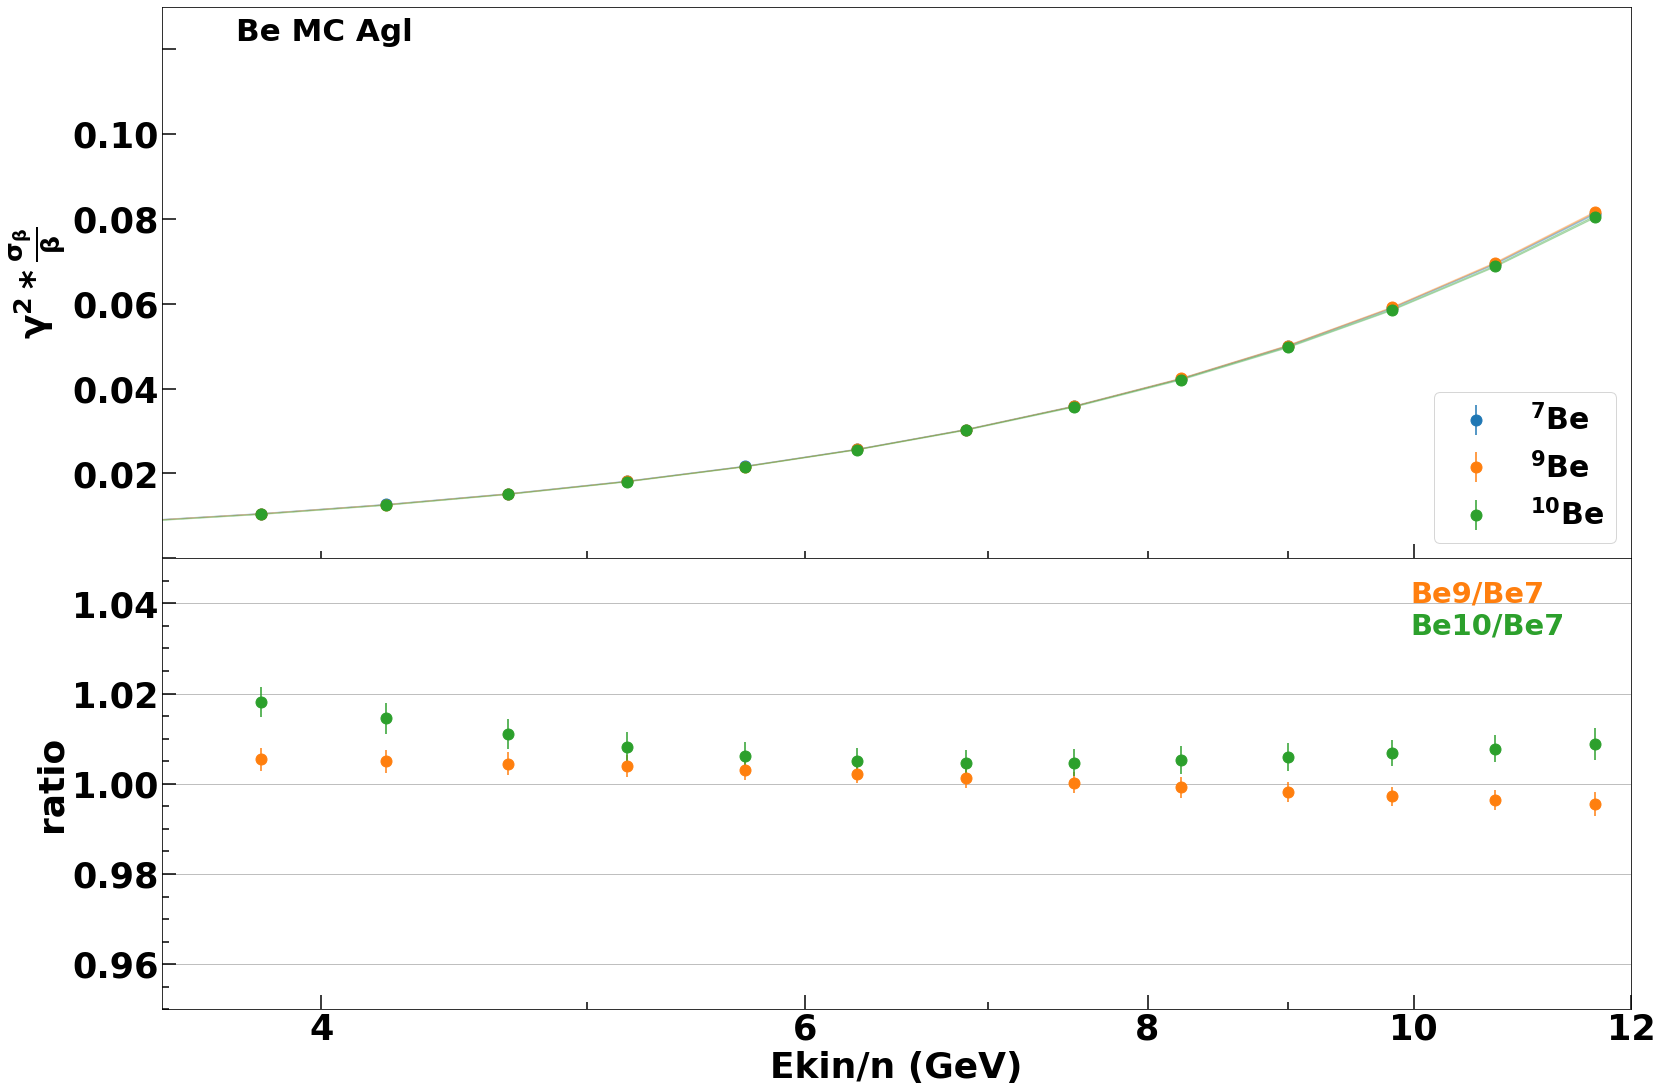

In [31]:
from tools.constants import MASS_NUCLEON_GEV
def calc_gamma_from_ekin(ekin):                                                                                                                                                                          
    gamma = ekin/MASS_NUCLEON_GEV + 1.0                                                                                                                                                                  
    return gamma  

x_ekin = get_bin_center(fbinning_energy())

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
graph_betaterm_vs_ekin_Agl = dict()
for iso in isotopes:
    
    xval_gamma = calc_gamma_from_ekin(x_ekin)
    print(xval_gamma)
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval_gamma), dict_polypar_beta_Agl[iso], upoly)
    #ax1.plot(x_ekin, yfit, "--",  color=ISOTOPES_COLOR[iso], label=f'{ISO_LABELS[iso]}')
    graph_betaterm_vs_ekin_Agl[iso] = MGraph(x_ekin, yfit, yfit_err)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval_gamma), dict_polypar_beta_Agl[iso], upoly)
    ax1.fill_between(x_ekin, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    plot_graph(fig, ax1, graph_betaterm_vs_ekin_Agl[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
graph_ratio_9 = graph_betaterm_vs_ekin_Agl['Be7']/graph_betaterm_vs_ekin_Agl['Be9']
graph_ratio_10 = graph_betaterm_vs_ekin_Agl['Be7']/graph_betaterm_vs_ekin_Agl['Be10']
plot_graph(fig, ax2, graph_ratio_9, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
plot_graph(fig, ax2, graph_ratio_10, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)  
ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')                                            
ax2.set_xlabel('Ekin/n (GeV)') 
ax1.legend(loc="lower right", fontsize=30) 
ax2.set_ylabel('ratio')
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylim([0.0, 0.13])
ax2.set_ylim([0.95, 1.05])
ax1.set_xlim([3.5, 12.0])
ax2.set_xlim([3.5, 12.0])

plt.subplots_adjust(hspace=.0)   
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([4, 6, 8, 10, 12]))
ax2.text(0.85, 0.95, "Be9/Be7", fontsize=FONTSIZE-1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be9'])
ax2.text(0.85, 0.88, "Be10/Be7", fontsize=FONTSIZE-1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be10'])
ax1.text(0.05, 0.98, "Be MC Agl", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax2.grid(axis='y')
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/plots/plot_resolutions_ekin'
savefig_tofile(fig, plotdir, f"betaterm_vs_ekin_Agl", show=True) 


Tof: mass resolution

In [32]:
def calc_massreso(rigreso, betaterm):
    massreso = np.sqrt(rigreso.yvalues**2 + betaterm.yvalues**2)
    massreso_err = rigreso.yvalues/massreso * rigreso.yerrs + betaterm.yvalues/massreso * betaterm.yerrs
    return massreso, massreso_err



[Text(0.01, 0, ''),
 Text(0.1, 0, ''),
 Text(1.0, 0, ''),
 Text(10.0, 0, ''),
 Text(100.0, 0, '')]

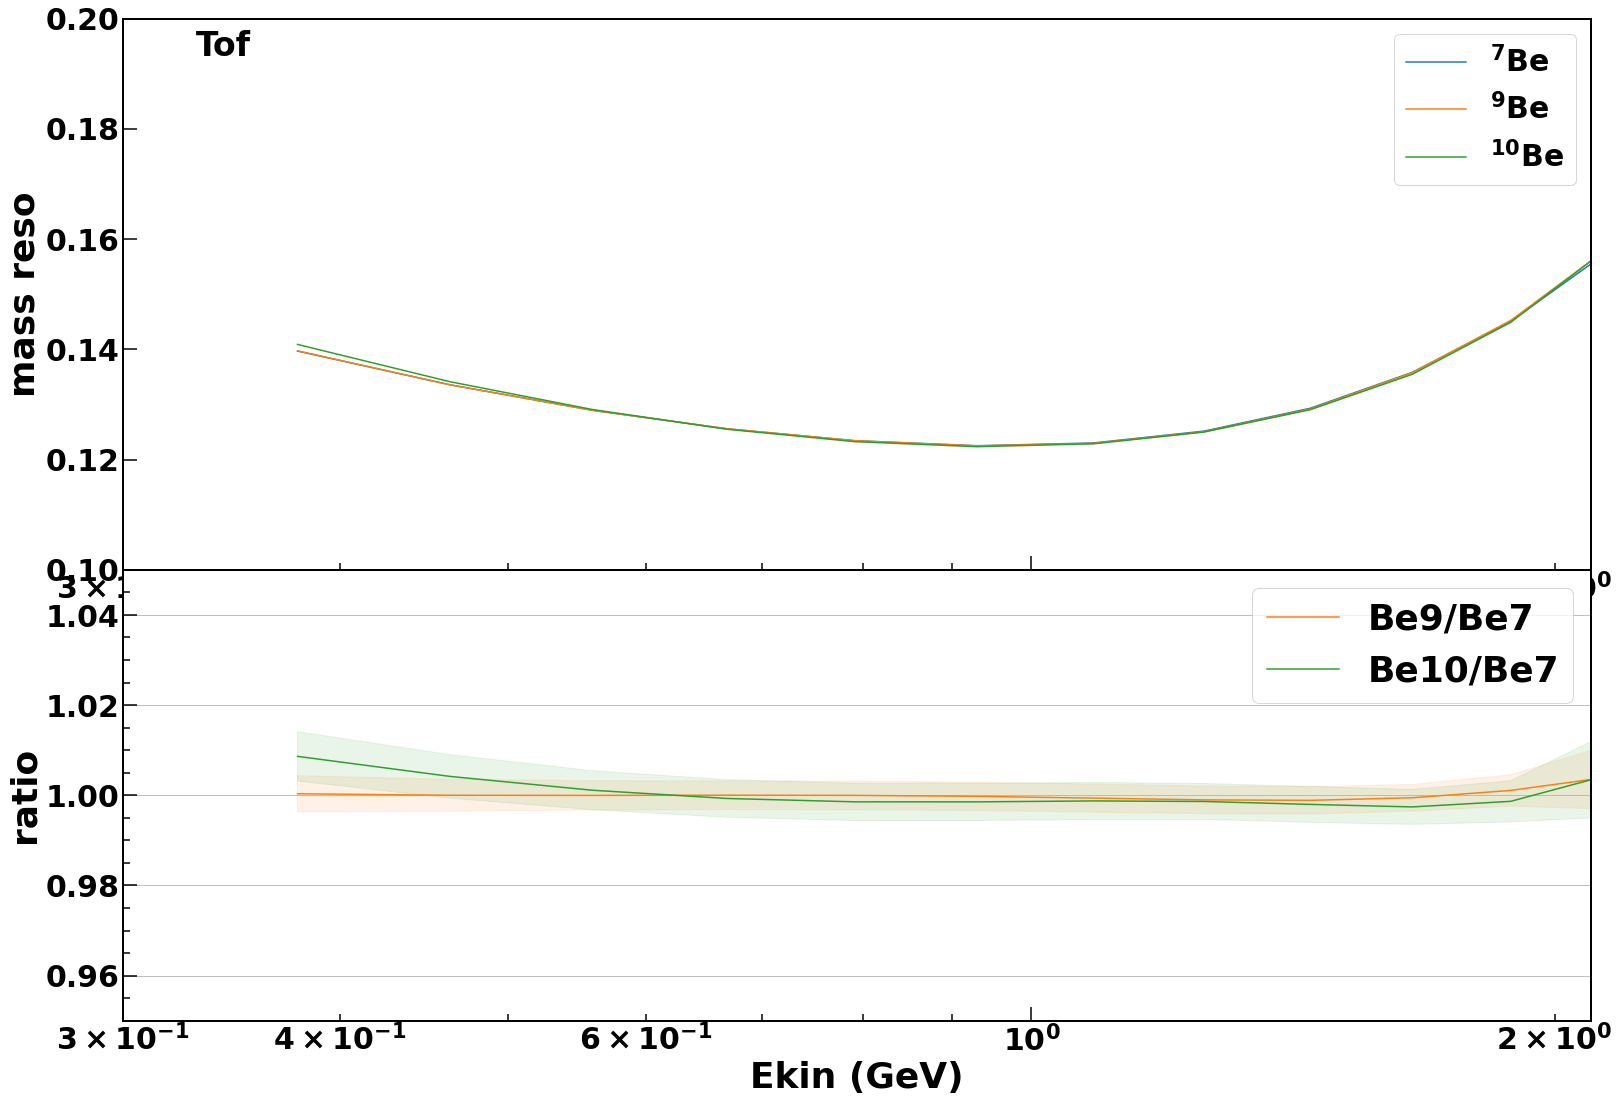

In [33]:
inverse_mass_reso_Tof = dict()
inverse_mass_reso_Tof_err = dict()
graph_inversemass_reso_Tof = dict()


for iso in isotopes:
    #print(graph_betaterm_vs_ekin_Tof[iso])
    #print(graph_rigreso_sigma[iso])
    inverse_mass_reso_Tof[iso], inverse_mass_reso_Tof_err[iso] =  calc_massreso(graph_rigreso_sigma[iso], graph_betaterm_vs_ekin_Tof[iso])
    
    graph_inversemass_reso_Tof[iso] = MGraph(graph_rigreso_sigma[iso].xvalues, inverse_mass_reso_Tof[iso], inverse_mass_reso_Tof_err[iso])
    
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_Tof[iso].xvalues, graph_inversemass_reso_Tof[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    plot_graph(fig, ax1, graph_inversemass_reso_Tof[iso], color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
mass_reso_ratio9_Tof = graph_inversemass_reso_Tof['Be9']/graph_inversemass_reso_Tof['Be7']
mass_reso_ratio10_Tof = graph_inversemass_reso_Tof['Be10']/graph_inversemass_reso_Tof['Be7']

#ax2.plot(mass_reso_ratio9_Tof.xvalues, mass_reso_ratio9_Tof.yvalues, "--",  color=ISOTOPES_COLOR['Be9'])  
#ax2.plot(mass_reso_ratio10_Tof.xvalues, mass_reso_ratio10_Tof.yvalues, "--",  color=ISOTOPES_COLOR['Be10'])  
plot_graph(fig, ax2, mass_reso_ratio9_Tof, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label='Be9/Be7')  
plot_graph(fig, ax2, mass_reso_ratio10_Tof, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be10/Be7')  
yratio_low_Tof = mass_reso_ratio9_Tof.yvalues - mass_reso_ratio9_Tof.yerrs
yratio_up_Tof = mass_reso_ratio9_Tof.yvalues + mass_reso_ratio9_Tof.yerrs
ax2.fill_between(mass_reso_ratio9_Tof.xvalues, yratio_low_Tof, yratio_up_Tof, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_Tof10 = mass_reso_ratio10_Tof.yvalues - mass_reso_ratio10_Tof.yerrs
yratio_up_Tof10 = mass_reso_ratio10_Tof.yvalues + mass_reso_ratio10_Tof.yerrs
ax2.fill_between(mass_reso_ratio10_Tof.xvalues, yratio_low_Tof10, yratio_up_Tof10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  

ax1.set_xlim([0.3, 2.1])
ax2.set_xlim([0.3, 2.1])
ax1.set_ylim([0.1, 0.2])
ax2.set_ylim([0.95, 1.05])
ax2.grid(axis='y')

ax1.set_ylabel('mass reso')                                            
ax2.set_xlabel('Ekin (GeV)') 
ax2.legend()
ax1.legend(loc="upper right", fontsize=30) 

ax1.text(0.05, 0.98, "Tof", fontsize=FONTSIZE+3, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
plt.subplots_adjust(hspace=.0)  
set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
ax2.set_ylabel('ratio')
ax1.set_xticklabels([])
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotfile, f"mass_resolution_tof_line1", show=True)
    

[Text(0.01, 0, ''),
 Text(0.1, 0, ''),
 Text(1.0, 0, ''),
 Text(10.0, 0, ''),
 Text(100.0, 0, '')]

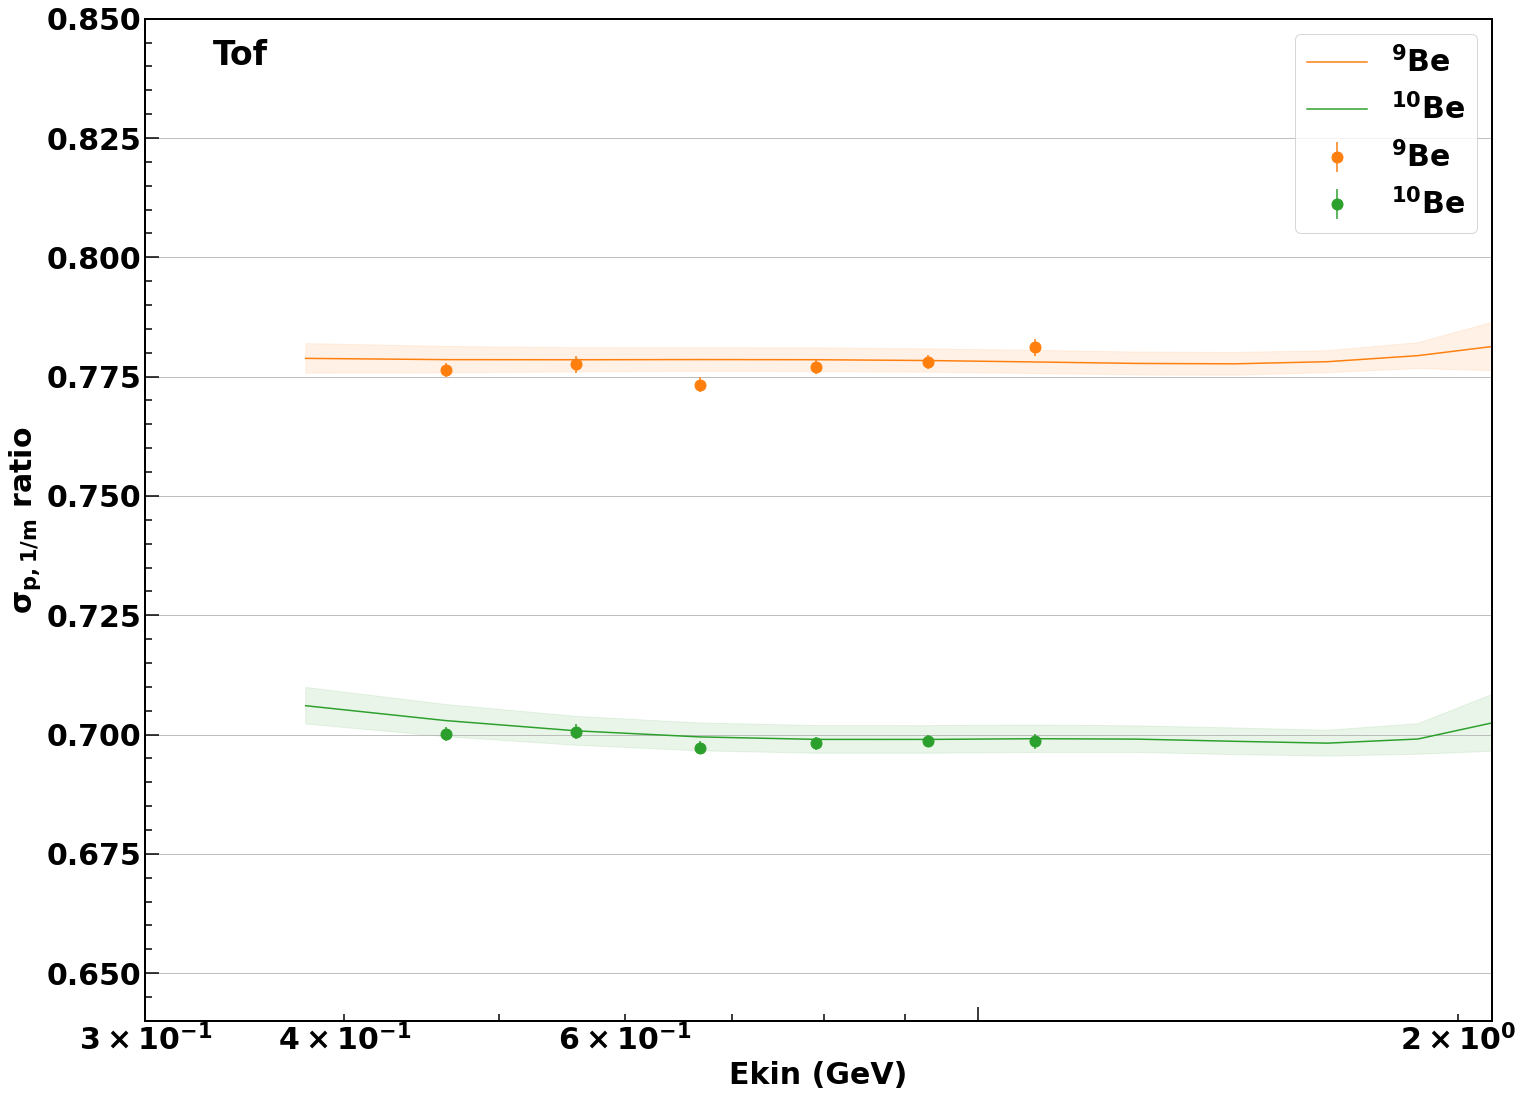

In [35]:
from tools.graphs import scale_graph

filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23/df_ratio_sigma_iter2.npz'

df_sigma_ratio = np.load(f'{filename}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
for dec in detectors:
    graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_10to7_{dec}")
        

fig, ax1 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

graph_ratiobe9_Tof = scale_graph(mass_reso_ratio9_Tof, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
graph_ratiobe10_Tof = scale_graph(mass_reso_ratio10_Tof, 7/10)
plot_graph(fig, ax1, graph_ratiobe9_Tof, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
plot_graph(fig, ax1, graph_mass_sigma_9to7['Tof'], color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
plot_graph(fig, ax1, graph_ratiobe10_Tof, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
plot_graph(fig, ax1, graph_mass_sigma_10to7['Tof'], color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
yratio_low_Tof = graph_ratiobe9_Tof.yvalues - graph_ratiobe9_Tof.yerrs
yratio_up_Tof = graph_ratiobe9_Tof.yvalues + graph_ratiobe9_Tof.yerrs
ax1.fill_between(graph_ratiobe9_Tof.xvalues, yratio_low_Tof, yratio_up_Tof, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_Tof10 = graph_ratiobe10_Tof.yvalues - graph_ratiobe10_Tof.yerrs
yratio_up_Tof10 = graph_ratiobe10_Tof.yvalues + graph_ratiobe10_Tof.yerrs
ax1.fill_between(graph_ratiobe10_Tof.xvalues, yratio_low_Tof10, yratio_up_Tof10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  
ax1.set_xlim([0.3, 2.1])
ax1.set_ylim([0.64, 0.85])
ax1.grid(axis='y')                                         
ax1.set_xlabel('Ekin (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.text(0.05, 0.98, "Tof", fontsize=FONTSIZE+3, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
set_plot_defaultstyle(ax1)

ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m}}$ ratio')
ax1.set_xticklabels([])
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotdir, f"mass_resolution_ratio_comfit_Tof", show=True)
    

Text(0.05, 0.98, 'NaF')

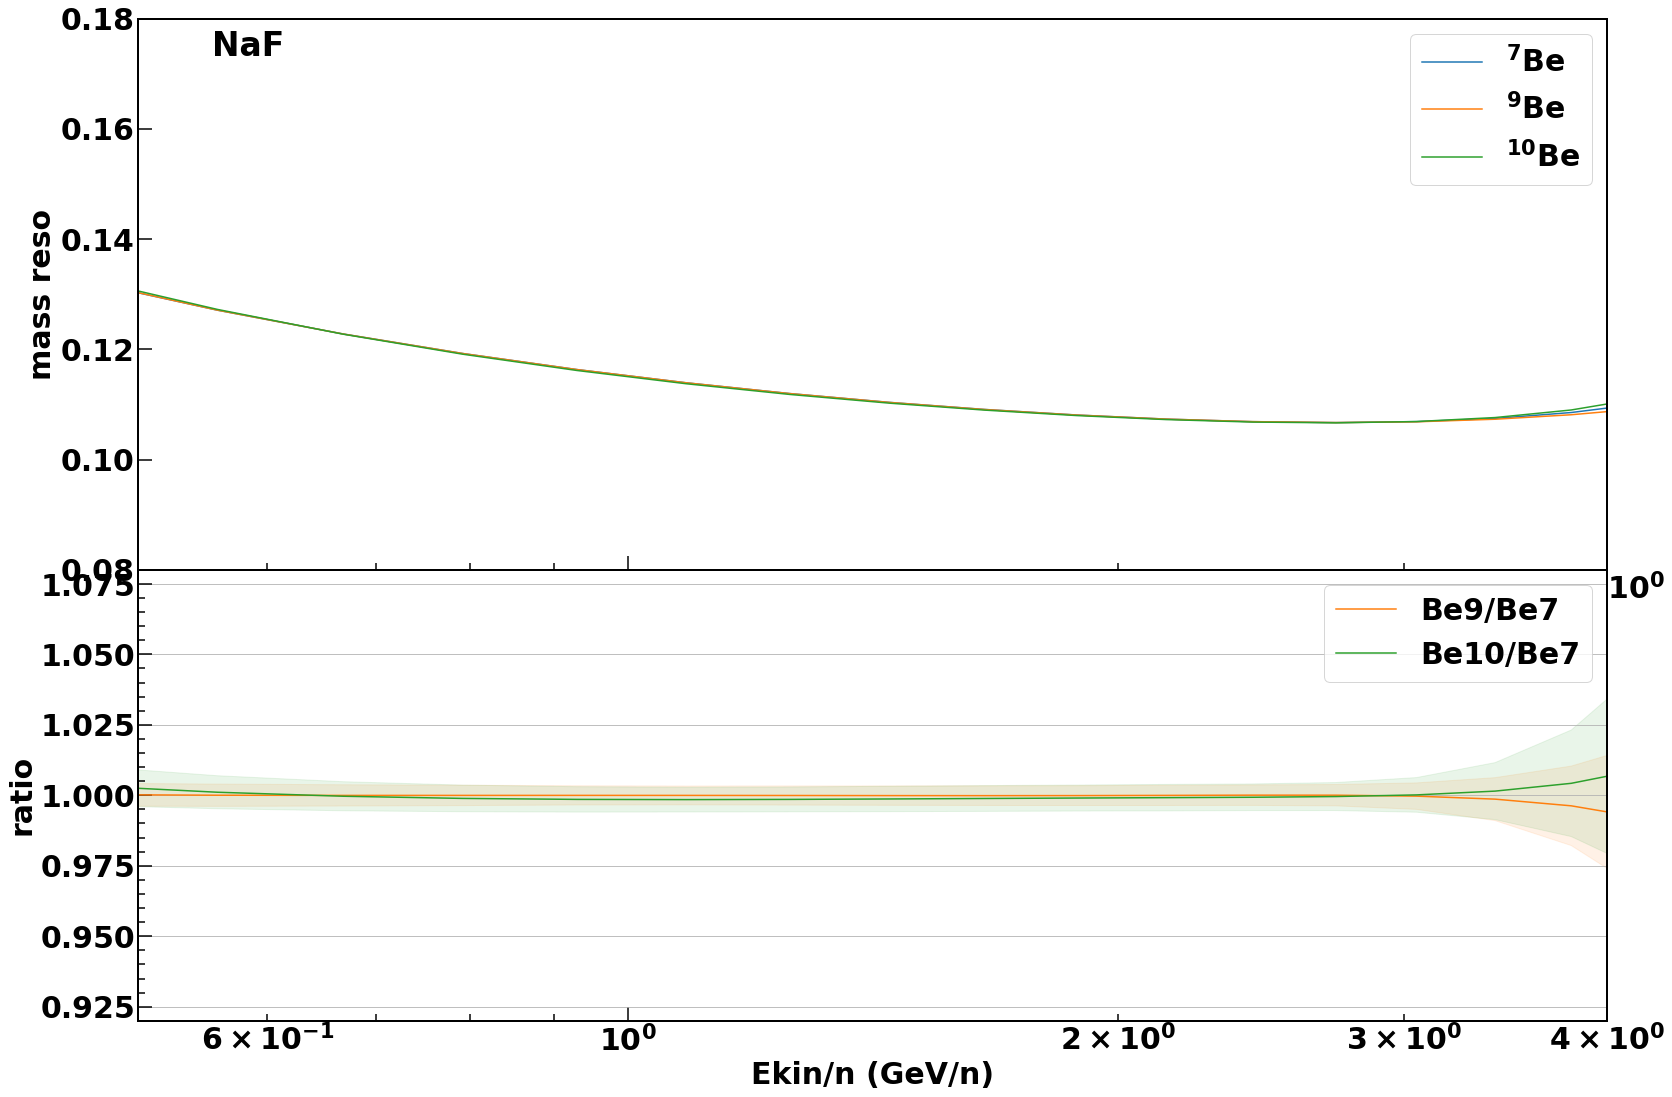

In [36]:
inverse_mass_reso_NaF = dict()
inverse_mass_reso_NaF_err = dict()
graph_inversemass_reso_NaF = dict()
for iso in isotopes:
    inverse_mass_reso_NaF[iso], inverse_mass_reso_NaF_err[iso] =  calc_massreso(graph_rigreso_sigma[iso], graph_betaterm_vs_ekin_NaF[iso])
    graph_inversemass_reso_NaF[iso] = MGraph(graph_rigreso_sigma[iso].xvalues, inverse_mass_reso_NaF[iso], inverse_mass_reso_NaF_err[iso])
    
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_NaF[iso].xvalues, graph_inversemass_reso_NaF[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    plot_graph(fig, ax1, graph_inversemass_reso_NaF[iso], color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
mass_reso_ratio9_NaF = graph_inversemass_reso_NaF['Be9']/graph_inversemass_reso_NaF['Be7']
mass_reso_ratio10_NaF = graph_inversemass_reso_NaF['Be10']/graph_inversemass_reso_NaF['Be7']

#ax2.plot(mass_reso_ratio9_NaF.xvalues, mass_reso_ratio9_NaF.yvalues, "--",  color=ISOTOPES_COLOR['Be9'])  
#ax2.plot(mass_reso_ratio10_NaF.xvalues, mass_reso_ratio10_NaF.yvalues, "--",  color=ISOTOPES_COLOR['Be10'])
plot_graph(fig, ax2, mass_reso_ratio9_NaF, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be9/Be7')  
plot_graph(fig, ax2, mass_reso_ratio10_NaF, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be10/Be7')  
yratio_low_NaF = mass_reso_ratio9_NaF.yvalues - mass_reso_ratio9_NaF.yerrs
yratio_up_NaF = mass_reso_ratio9_NaF.yvalues + mass_reso_ratio9_NaF.yerrs
ax2.fill_between(mass_reso_ratio9_NaF.xvalues, yratio_low_NaF, yratio_up_NaF, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_NaF10 = mass_reso_ratio10_NaF.yvalues - mass_reso_ratio10_NaF.yerrs
yratio_up_NaF10 = mass_reso_ratio10_NaF.yvalues + mass_reso_ratio10_NaF.yerrs
ax2.fill_between(mass_reso_ratio10_NaF.xvalues, yratio_low_NaF10, yratio_up_NaF10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  

ax1.set_xlim([0.5, 4.0])
ax2.set_xlim([0.5, 4.0])
ax1.set_ylim([0.08, 0.18])
ax2.set_ylim([0.92, 1.08])
ax2.grid(axis='y')
ax1.set_ylabel('mass reso')                                            
ax2.set_xlabel('Ekin/n (GeV/n)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0) 

set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
ax2.set_ylabel('ratio')
ax1.set_xticklabels([])
ax2.legend()
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
ax1.text(0.05, 0.98, "NaF", fontsize=FONTSIZE+3, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotdir, f"mass_resolution_NaF_line1", show=True)

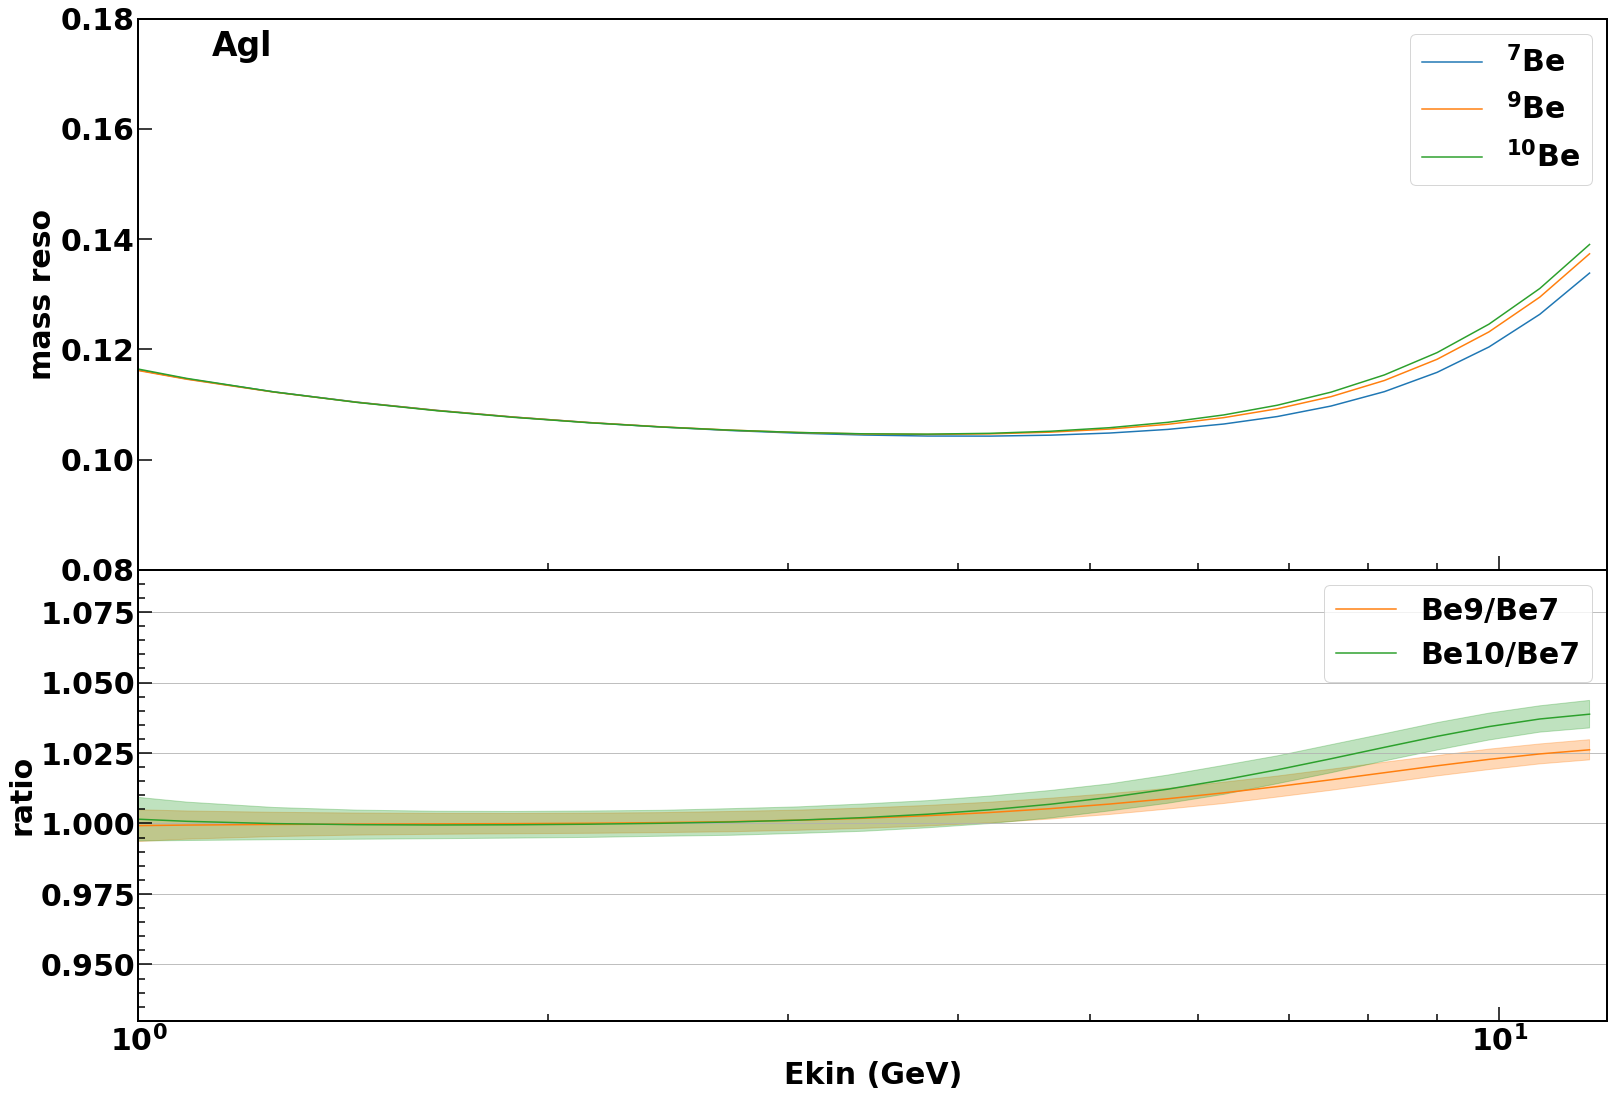

In [38]:

inverse_mass_reso_Agl = dict()
inverse_mass_reso_Agl_err = dict()
graph_inversemass_reso_Agl = dict()
for iso in isotopes:
    inverse_mass_reso_Agl[iso], inverse_mass_reso_Agl_err[iso] =  calc_massreso(graph_rigreso_sigma[iso], graph_betaterm_vs_ekin_Agl[iso])
    graph_inversemass_reso_Agl[iso] = MGraph(graph_rigreso_sigma[iso].xvalues, inverse_mass_reso_Agl[iso], inverse_mass_reso_Agl_err[iso])
    
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_Agl[iso].xvalues, graph_inversemass_reso_Agl[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    plot_graph(fig, ax1, graph_inversemass_reso_Agl[iso], color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
mass_reso_ratio9_Agl = graph_inversemass_reso_Agl['Be9']/graph_inversemass_reso_Agl['Be7']
mass_reso_ratio10_Agl = graph_inversemass_reso_Agl['Be10']/graph_inversemass_reso_Agl['Be7']

#ax2.plot(mass_reso_ratio9_Agl.xvalues, mass_reso_ratio9_Agl.yvalues, "--",  color=ISOTOPES_COLOR['Be9'])  
#ax2.plot(mass_reso_ratio10_Agl.xvalues, mass_reso_ratio10_Agl.yvalues, "--",  color=ISOTOPES_COLOR['Be10'])
plot_graph(fig, ax2, mass_reso_ratio9_Agl, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be9/Be7')  
plot_graph(fig, ax2, mass_reso_ratio10_Agl, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'Be10/Be7')  
yratio_low_Agl = mass_reso_ratio9_Agl.yvalues - mass_reso_ratio9_Agl.yerrs
yratio_up_Agl = mass_reso_ratio9_Agl.yvalues + mass_reso_ratio9_Agl.yerrs
yratio_low_Agl10 = mass_reso_ratio10_Agl.yvalues - mass_reso_ratio10_Agl.yerrs
yratio_up_Agl10 = mass_reso_ratio10_Agl.yvalues + mass_reso_ratio10_Agl.yerrs
ax2.fill_between(mass_reso_ratio9_Agl.xvalues, yratio_low_Agl, yratio_up_Agl, color=ISOTOPES_COLOR['Be9'], alpha=0.3)  
ax2.fill_between(mass_reso_ratio10_Agl.xvalues, yratio_low_Agl10, yratio_up_Agl10, color=ISOTOPES_COLOR['Be10'], alpha=0.3)  

ax1.set_xlim([1, 12.0])
ax2.set_xlim([1, 12.0])
ax1.set_ylim([0.08, 0.18])
ax2.set_ylim([0.93, 1.09])
ax2.grid(axis='y')
ax1.set_ylabel('mass reso')                                            
ax2.set_xlabel('Ekin (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0) 
set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
ax2.set_ylabel('ratio')
ax1.set_xticklabels([])
ax2.legend()

ax1.text(0.05, 0.98, "Agl", fontsize=FONTSIZE+3, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/plots/plot_resolutions_ekin'
savefig_tofile(fig, plotdir, f"mass_resolution_Agl_line1", show=True)

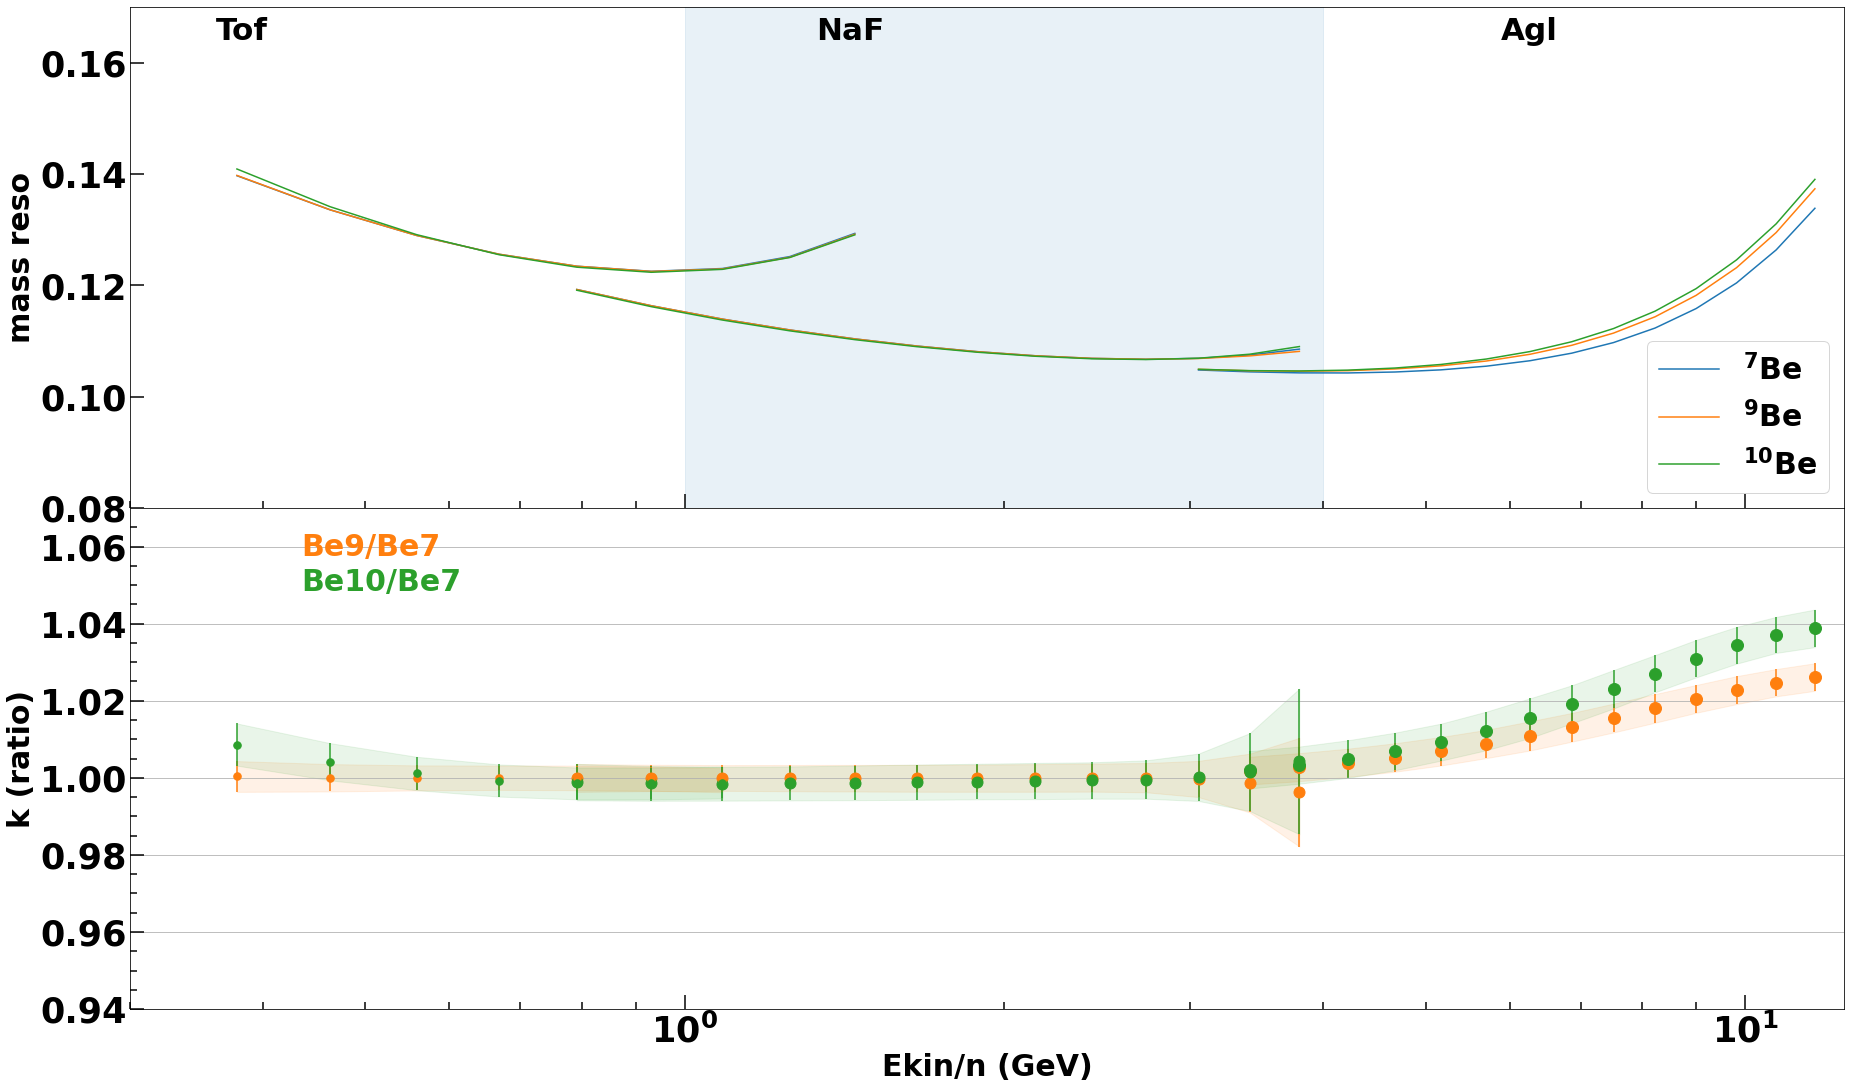

In [39]:
from tools.graphs import slice_graph_by_value
from tools.constants import ANALYSIS_RANGE_EKIN

energy_range = {"Tof": [0.3, 1.1], "NaF": np.array([0.8, 3.8]), "Agl": np.array([3.5, 12])}

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(28, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_Agl[iso].xvalues, graph_inversemass_reso_Agl[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    sub_graph_massreso_Agl = slice_graph_by_value(graph_inversemass_reso_Agl[iso], np.array([3.0, 12]))
    sub_graph_massreso_NaF = slice_graph_by_value(graph_inversemass_reso_NaF[iso], np.array([0.8, 3.8]))
    sub_graph_massreso_Tof = slice_graph_by_value(graph_inversemass_reso_Tof[iso], np.array([0.3, 1.5]))
    plot_graph(fig, ax1, sub_graph_massreso_Agl, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=25, label=f'{ISO_LABELS[iso]}')
    plot_graph(fig, ax1, sub_graph_massreso_NaF, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=20)  
    plot_graph(fig, ax1, sub_graph_massreso_Tof, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=15)  
mass_reso_ratio9_Agl = graph_inversemass_reso_Agl['Be9']/graph_inversemass_reso_Agl['Be7']
mass_reso_ratio10_Agl = graph_inversemass_reso_Agl['Be10']/graph_inversemass_reso_Agl['Be7']

#ax2.plot(mass_reso_ratio9_Agl.xvalues, mass_reso_ratio9_Agl.yvalues, "--",  color=ISOTOPES_COLOR['Be9'])  
#ax2.plot(mass_reso_ratio10_Agl.xvalues, mass_reso_ratio10_Agl.yvalues, "--",  color=ISOTOPES_COLOR['Be10'])
sub_mass_reso_ratio9_Agl = slice_graph_by_value(mass_reso_ratio9_Agl, energy_range['Agl'])
sub_mass_reso_ratio10_Agl = slice_graph_by_value(mass_reso_ratio10_Agl, energy_range['Agl'])

sub_mass_reso_ratio9_NaF = slice_graph_by_value(mass_reso_ratio9_NaF, energy_range['NaF'])
sub_mass_reso_ratio10_NaF = slice_graph_by_value(mass_reso_ratio10_NaF, energy_range['NaF'])

sub_mass_reso_ratio9_Tof = slice_graph_by_value(mass_reso_ratio9_Tof, energy_range['Tof'])
sub_mass_reso_ratio10_Tof = slice_graph_by_value(mass_reso_ratio10_Tof, energy_range['Tof'])




plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio9_Agl, energy_range['Agl']), color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=24, label='Be9/Be7')  
plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio10_Agl, energy_range['Agl']), color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=24, label='Be10/Be7') 

plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio9_NaF, energy_range['NaF']), color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)  
plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio10_NaF, energy_range['NaF']), color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)  

plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio9_Tof, energy_range['Tof']), color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=15)  
plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio10_Tof, energy_range['Tof']), color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=15)  


ax1.text(0.05, 0.98, "Tof", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.text(0.4, 0.98, "NaF", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.text(0.8, 0.98, "Agl", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")

ax2.text(0.1, 0.95, "Be9/Be7", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be9'])
ax2.text(0.1, 0.88, "Be10/Be7", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be10'])

yratio_low_Agl9 = sub_mass_reso_ratio9_Agl.yvalues - sub_mass_reso_ratio9_Agl.yerrs
yratio_up_Agl9 = sub_mass_reso_ratio9_Agl.yvalues + sub_mass_reso_ratio9_Agl.yerrs
yratio_low_Agl10 = sub_mass_reso_ratio10_Agl.yvalues - sub_mass_reso_ratio10_Agl.yerrs
yratio_up_Agl10 = sub_mass_reso_ratio10_Agl.yvalues + sub_mass_reso_ratio10_Agl.yerrs
ax2.fill_between(sub_mass_reso_ratio9_Agl.xvalues, yratio_low_Agl9, yratio_up_Agl9, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  
ax2.fill_between(sub_mass_reso_ratio10_Agl.xvalues, yratio_low_Agl10, yratio_up_Agl10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  


yratio_low_NaF9 = sub_mass_reso_ratio9_NaF.yvalues - sub_mass_reso_ratio9_NaF.yerrs
yratio_up_NaF9 = sub_mass_reso_ratio9_NaF.yvalues + sub_mass_reso_ratio9_NaF.yerrs
yratio_low_NaF10 = sub_mass_reso_ratio10_NaF.yvalues - sub_mass_reso_ratio10_NaF.yerrs
yratio_up_NaF10 = sub_mass_reso_ratio10_NaF.yvalues + sub_mass_reso_ratio10_NaF.yerrs
ax2.fill_between(sub_mass_reso_ratio9_NaF.xvalues, yratio_low_NaF9, yratio_up_NaF9, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  
ax2.fill_between(sub_mass_reso_ratio10_NaF.xvalues, yratio_low_NaF10, yratio_up_NaF10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  

yratio_low_Tof9 = sub_mass_reso_ratio9_Tof.yvalues - sub_mass_reso_ratio9_Tof.yerrs
yratio_up_Tof9 = sub_mass_reso_ratio9_Tof.yvalues + sub_mass_reso_ratio9_Tof.yerrs
yratio_low_Tof10 = sub_mass_reso_ratio10_Tof.yvalues - sub_mass_reso_ratio10_Tof.yerrs
yratio_up_Tof10 = sub_mass_reso_ratio10_Tof.yvalues + sub_mass_reso_ratio10_Tof.yerrs
ax2.fill_between(sub_mass_reso_ratio9_Tof.xvalues, yratio_low_Tof9, yratio_up_Tof9, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  
ax2.fill_between(sub_mass_reso_ratio10_Tof.xvalues, yratio_low_Tof10, yratio_up_Tof10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  


ax1.fill_betweenx(np.linspace(0.06, 0.2, 100), ANALYSIS_RANGE_EKIN['NaF'][0], ANALYSIS_RANGE_EKIN['NaF'][1], alpha=0.1, color='tab:blue') 

ax1.set_xlim([0.3, 12.4])
ax2.set_xlim([0.3, 12.4])
ax1.set_ylim([0.08, 0.17])
ax2.set_ylim([0.94, 1.07])
ax2.grid(axis='y')
ax1.set_ylabel('mass reso')  
ax2.set_ylabel('k (ratio)')  
ax2.set_xlabel('Ekin/n (GeV)') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0) 
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
savefig_tofile(fig, plotdir, f"mass_resolution_v1", show=True)


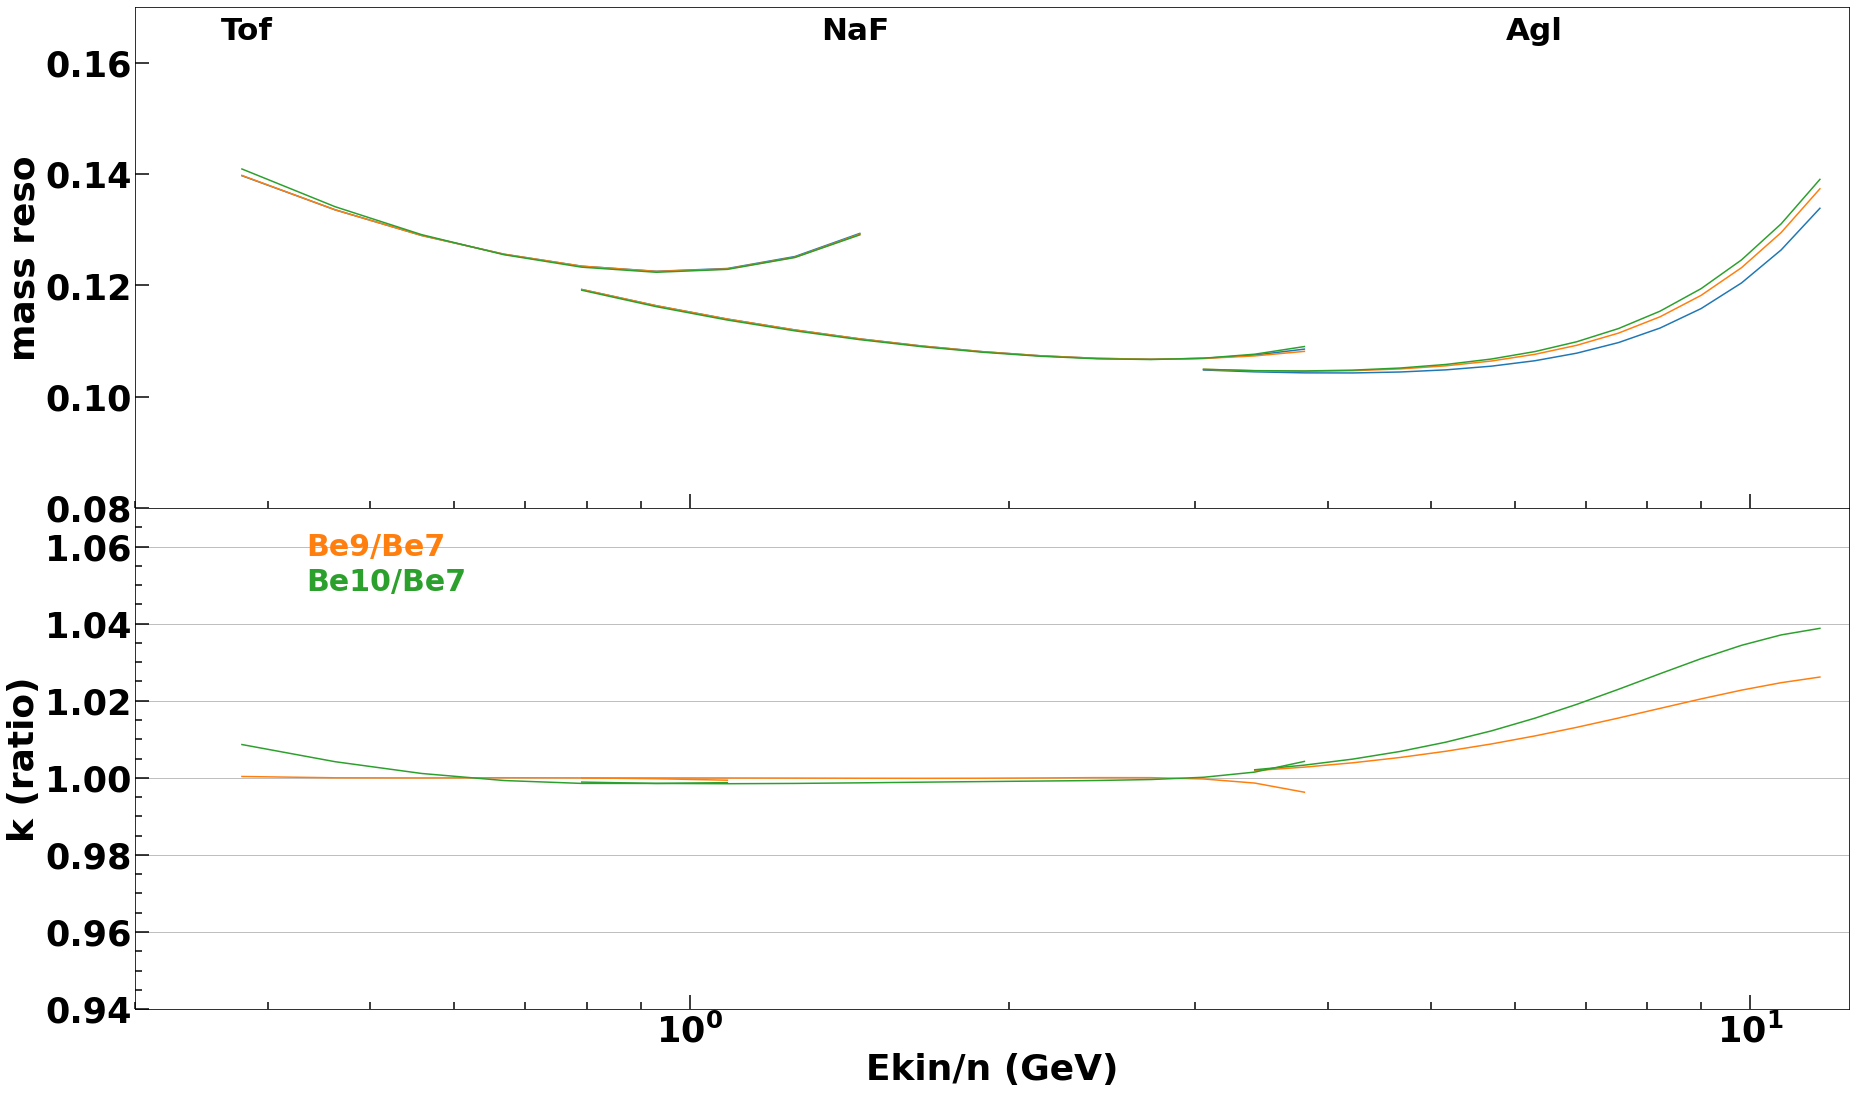

In [61]:
from tools.graphs import slice_graph_by_value
from tools.constants import ANALYSIS_RANGE_EKIN

energy_range = {"Tof": [0.3, 1.1], "NaF": np.array([0.8, 3.8]), "Agl": np.array([3.5, 12])}

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(28, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_Agl[iso].xvalues, graph_inversemass_reso_Agl[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    sub_graph_massreso_Agl = slice_graph_by_value(graph_inversemass_reso_Agl[iso], np.array([3.0, 12]))
    sub_graph_massreso_NaF = slice_graph_by_value(graph_inversemass_reso_NaF[iso], np.array([0.8, 3.8]))
    sub_graph_massreso_Tof = slice_graph_by_value(graph_inversemass_reso_Tof[iso], np.array([0.3, 1.5]))
    plot_graph(fig, ax1, sub_graph_massreso_Agl, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=25, label=f'{ISO_LABELS[iso]}')
    plot_graph(fig, ax1, sub_graph_massreso_NaF, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=20)  
    plot_graph(fig, ax1, sub_graph_massreso_Tof, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=15)  
mass_reso_ratio9_Agl = graph_inversemass_reso_Agl['Be9']/graph_inversemass_reso_Agl['Be7']
mass_reso_ratio10_Agl = graph_inversemass_reso_Agl['Be10']/graph_inversemass_reso_Agl['Be7']

#ax2.plot(mass_reso_ratio9_Agl.xvalues, mass_reso_ratio9_Agl.yvalues, "--",  color=ISOTOPES_COLOR['Be9'])  
#ax2.plot(mass_reso_ratio10_Agl.xvalues, mass_reso_ratio10_Agl.yvalues, "--",  color=ISOTOPES_COLOR['Be10'])
sub_mass_reso_ratio9_Agl = slice_graph_by_value(mass_reso_ratio9_Agl, energy_range['Agl'])
sub_mass_reso_ratio10_Agl = slice_graph_by_value(mass_reso_ratio10_Agl, energy_range['Agl'])

sub_mass_reso_ratio9_NaF = slice_graph_by_value(mass_reso_ratio9_NaF, energy_range['NaF'])
sub_mass_reso_ratio10_NaF = slice_graph_by_value(mass_reso_ratio10_NaF, energy_range['NaF'])

sub_mass_reso_ratio9_Tof = slice_graph_by_value(mass_reso_ratio9_Tof, energy_range['Tof'])
sub_mass_reso_ratio10_Tof = slice_graph_by_value(mass_reso_ratio10_Tof, energy_range['Tof'])




plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio9_Agl, energy_range['Agl']), color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=24, label='Be9/Be7')  
plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio10_Agl, energy_range['Agl']), color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=True, ylog=False, scale=None, markersize=24, label='Be10/Be7') 

plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio9_NaF, energy_range['NaF']), color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22)  
plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio10_NaF, energy_range['NaF']), color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22)  

plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio9_Tof, energy_range['Tof']), color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=15)  
plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio10_Tof, energy_range['Tof']), color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=True, ylog=False, scale=None, markersize=15)  


ax1.text(0.05, 0.98, "Tof", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.text(0.4, 0.98, "NaF", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.text(0.8, 0.98, "Agl", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")

ax2.text(0.1, 0.95, "Be9/Be7", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be9'])
ax2.text(0.1, 0.88, "Be10/Be7", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be10'])

yratio_low_Agl9 = sub_mass_reso_ratio9_Agl.yvalues - sub_mass_reso_ratio9_Agl.yerrs
yratio_up_Agl9 = sub_mass_reso_ratio9_Agl.yvalues + sub_mass_reso_ratio9_Agl.yerrs
yratio_low_Agl10 = sub_mass_reso_ratio10_Agl.yvalues - sub_mass_reso_ratio10_Agl.yerrs
yratio_up_Agl10 = sub_mass_reso_ratio10_Agl.yvalues + sub_mass_reso_ratio10_Agl.yerrs
#ax2.fill_between(sub_mass_reso_ratio9_Agl.xvalues, yratio_low_Agl9, yratio_up_Agl9, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  
#ax2.fill_between(sub_mass_reso_ratio10_Agl.xvalues, yratio_low_Agl10, yratio_up_Agl10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  


yratio_low_NaF9 = sub_mass_reso_ratio9_NaF.yvalues - sub_mass_reso_ratio9_NaF.yerrs
yratio_up_NaF9 = sub_mass_reso_ratio9_NaF.yvalues + sub_mass_reso_ratio9_NaF.yerrs
yratio_low_NaF10 = sub_mass_reso_ratio10_NaF.yvalues - sub_mass_reso_ratio10_NaF.yerrs
yratio_up_NaF10 = sub_mass_reso_ratio10_NaF.yvalues + sub_mass_reso_ratio10_NaF.yerrs
#ax2.fill_between(sub_mass_reso_ratio9_NaF.xvalues, yratio_low_NaF9, yratio_up_NaF9, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  
#ax2.fill_between(sub_mass_reso_ratio10_NaF.xvalues, yratio_low_NaF10, yratio_up_NaF10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  

yratio_low_Tof9 = sub_mass_reso_ratio9_Tof.yvalues - sub_mass_reso_ratio9_Tof.yerrs
yratio_up_Tof9 = sub_mass_reso_ratio9_Tof.yvalues + sub_mass_reso_ratio9_Tof.yerrs
yratio_low_Tof10 = sub_mass_reso_ratio10_Tof.yvalues - sub_mass_reso_ratio10_Tof.yerrs
yratio_up_Tof10 = sub_mass_reso_ratio10_Tof.yvalues + sub_mass_reso_ratio10_Tof.yerrs
#ax2.fill_between(sub_mass_reso_ratio9_Tof.xvalues, yratio_low_Tof9, yratio_up_Tof9, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  
#ax2.fill_between(sub_mass_reso_ratio10_Tof.xvalues, yratio_low_Tof10, yratio_up_Tof10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  


#ax1.fill_betweenx(np.linspace(0.06, 0.2, 100), ANALYSIS_RANGE_EKIN['NaF'][0], ANALYSIS_RANGE_EKIN['NaF'][1], alpha=0.1, color='tab:blue') 

ax1.set_xlim([0.3, 12.4])
ax2.set_xlim([0.3, 12.4])
ax1.set_ylim([0.08, 0.17])
ax2.set_ylim([0.94, 1.07])
ax2.grid(axis='y')
ax1.set_ylabel('mass reso')  
ax2.set_ylabel('k (ratio)')  
ax2.set_xlabel('Ekin/n (GeV)') 
#ax1.legend(loc="lower right", fontthensize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0) 

#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
#savefig_tofile(fig, plotdir, f"mass_resolution_v2", show=True)


/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008


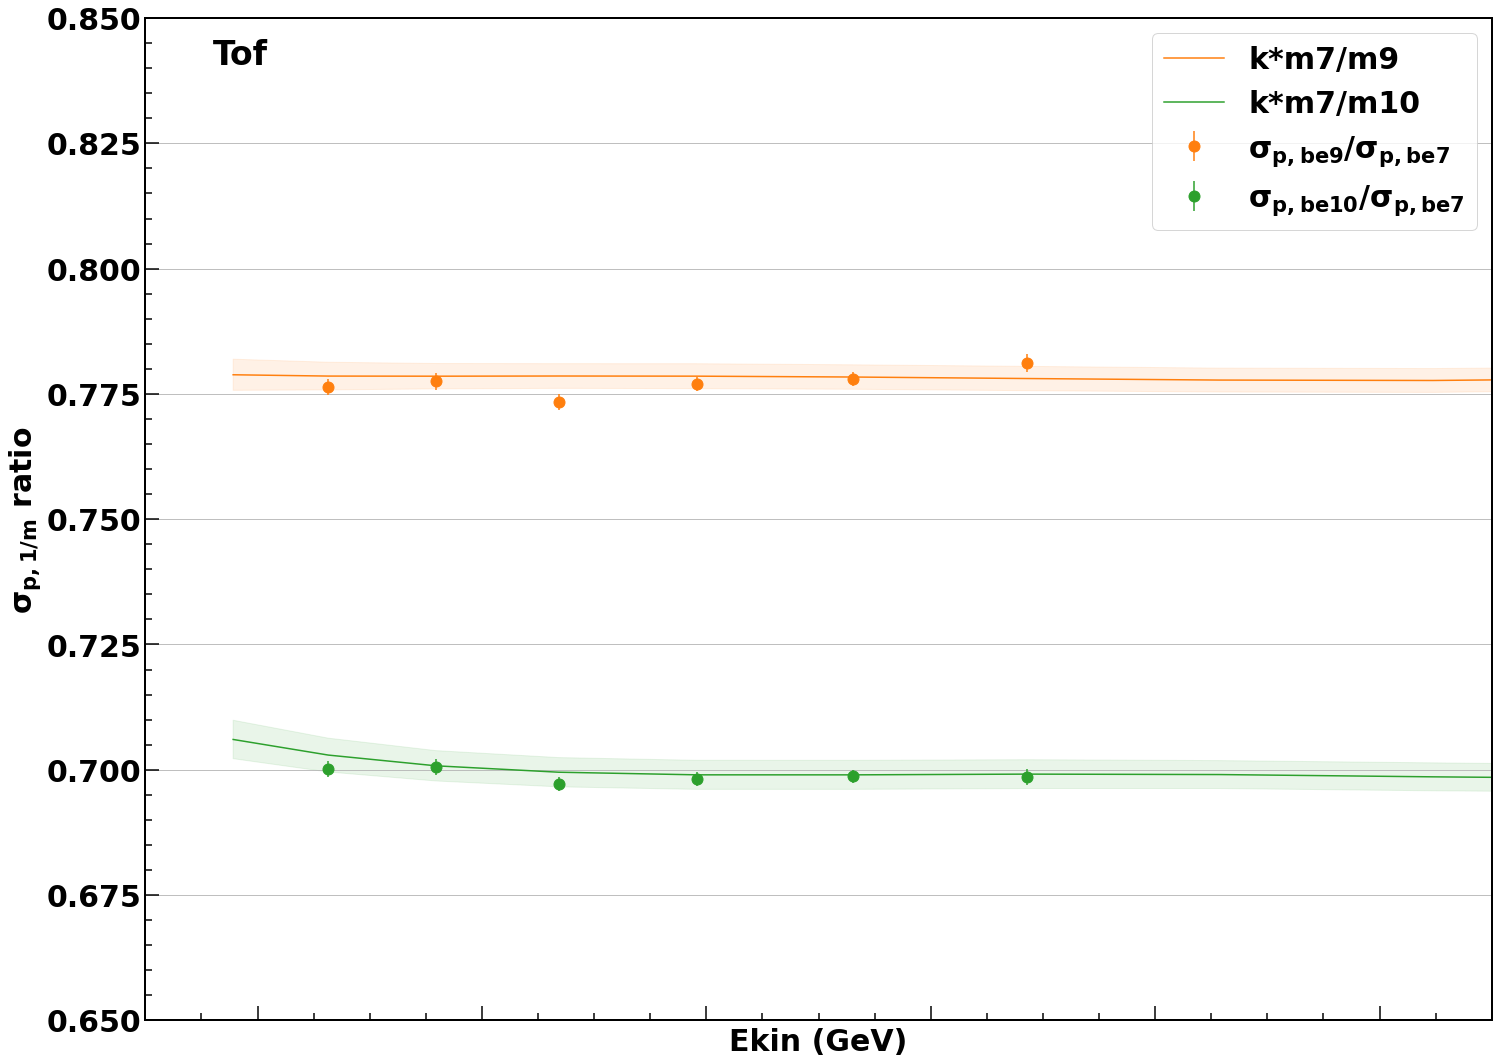

In [41]:

fig, ax1 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

graph_ratiobe9_Tof = scale_graph(mass_reso_ratio9_Tof, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
graph_ratiobe10_Tof = scale_graph(mass_reso_ratio10_Tof, 7/10)

plot_graph(fig, ax1, graph_ratiobe9_Tof, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'k*m7/m9')  
plot_graph(fig, ax1, graph_mass_sigma_9to7['Tof'], color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{\sigma_{p,be9}/\sigma_{p, be7}}$')  
plot_graph(fig, ax1, graph_ratiobe10_Tof, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'k*m7/m10')  
plot_graph(fig, ax1, graph_mass_sigma_10to7['Tof'], color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{\sigma_{p,be10}/\sigma_{p, be7}}$')  


yratio_low_Tof = graph_ratiobe9_Tof.yvalues - graph_ratiobe9_Tof.yerrs
yratio_up_Tof = graph_ratiobe9_Tof.yvalues + graph_ratiobe9_Tof.yerrs
ax1.fill_between(graph_ratiobe9_Tof.xvalues, yratio_low_Tof, yratio_up_Tof, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_Tof10 = graph_ratiobe10_Tof.yvalues - graph_ratiobe10_Tof.yerrs
yratio_up_Tof10 = graph_ratiobe10_Tof.yvalues + graph_ratiobe10_Tof.yerrs
ax1.fill_between(graph_ratiobe10_Tof.xvalues, yratio_low_Tof10, yratio_up_Tof10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  
ax1.set_xlim([0.3, 1.5])
ax1.set_ylim([0.65, 0.85])
ax1.grid(axis='y')                                         
ax1.set_xlabel('Ekin (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.text(0.05, 0.98, "Tof", fontsize=FONTSIZE+3, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")

print(plotdir)
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m}}$ ratio')
ax1.set_xticklabels([])
set_plot_defaultstyle(ax1)
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/plots/plot_resolutions_ekin'
#savefig_tofile(fig, plotdir, f"mass_resolution_ratio_comfit_Tof1", show=True)
    

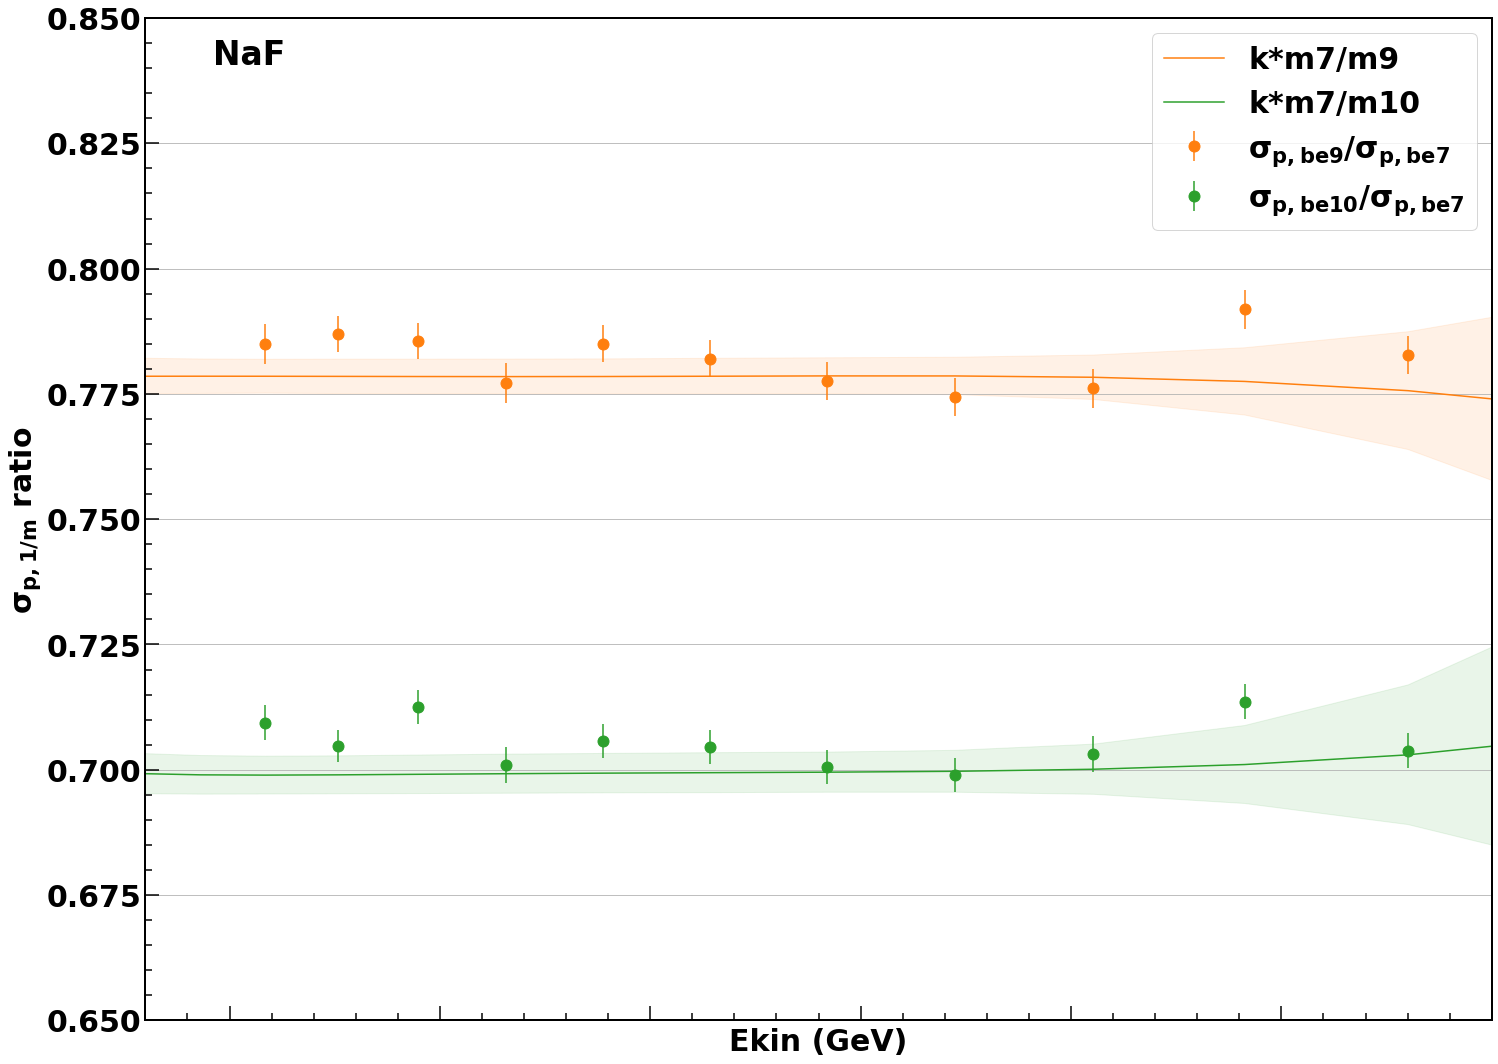

In [42]:
fig, ax1 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

graph_ratiobe9_NaF = scale_graph(mass_reso_ratio9_NaF, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
graph_ratiobe10_NaF = scale_graph(mass_reso_ratio10_NaF, 7/10)

plot_graph(fig, ax1, graph_ratiobe9_NaF, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'k*m7/m9')  
plot_graph(fig, ax1, graph_mass_sigma_9to7['NaF'], color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{\sigma_{p,be9}/\sigma_{p, be7}}$')  
plot_graph(fig, ax1, graph_ratiobe10_NaF, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'k*m7/m10')  
plot_graph(fig, ax1, graph_mass_sigma_10to7['NaF'], color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{\sigma_{p,be10}/\sigma_{p, be7}}$')  


yratio_low_NaF = (graph_ratiobe9_NaF.yvalues - graph_ratiobe9_NaF.yerrs) * 0.999
yratio_up_NaF = (graph_ratiobe9_NaF.yvalues + graph_ratiobe9_NaF.yerrs) * 1.001
ax1.fill_between(graph_ratiobe9_NaF.xvalues, yratio_low_NaF, yratio_up_NaF, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_NaF10 = (graph_ratiobe10_NaF.yvalues - graph_ratiobe10_NaF.yerrs) * 0.999
yratio_up_NaF10 = (graph_ratiobe10_NaF.yvalues + graph_ratiobe10_NaF.yerrs) * 1.001
ax1.fill_between(graph_ratiobe10_NaF.xvalues, yratio_low_NaF10, yratio_up_NaF10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  
ax1.set_xlim([0.8, 4.0])
ax1.set_ylim([0.65, 0.85])
ax1.grid(axis='y')                                         
ax1.set_xlabel('Ekin (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.text(0.05, 0.98, "NaF", fontsize=FONTSIZE+3, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m}}$ ratio')
ax1.set_xticklabels([])
set_plot_defaultstyle(ax1)
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/plots/plot_resolutions_ekin'
savefig_tofile(fig, plotdir, f"mass_resolution_ratio_comfit_NaF1", show=True)

Text(0.05, 0.98, 'Aerogel')

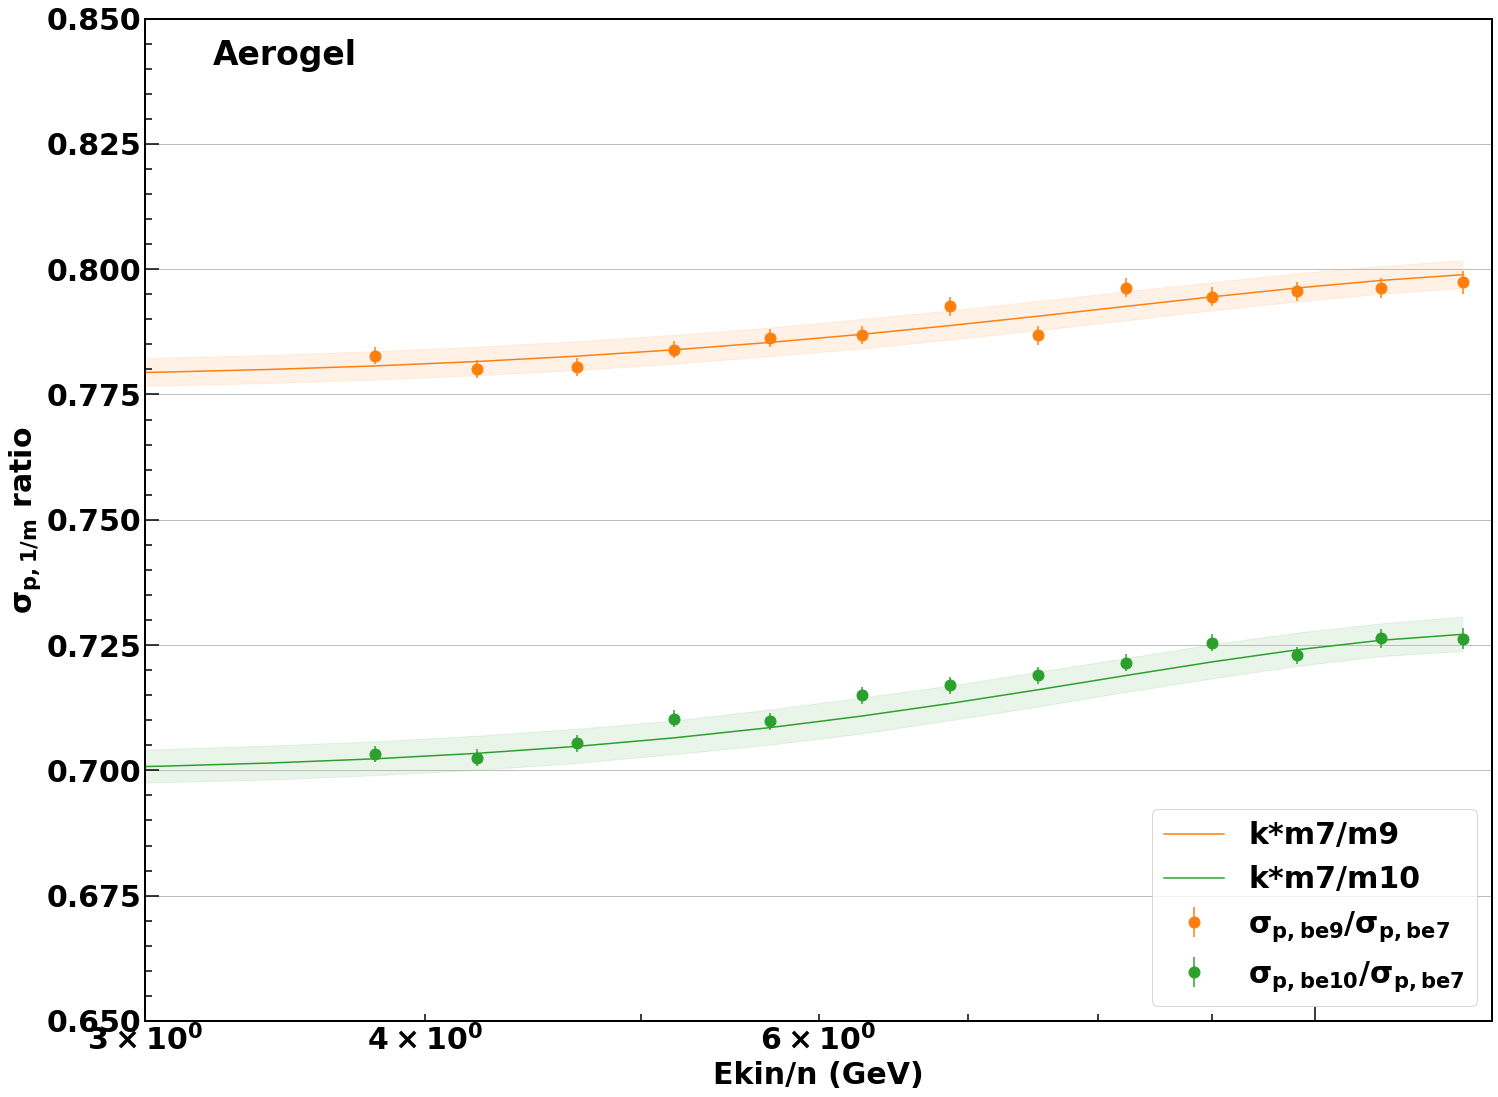

In [43]:
fig, ax1 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

graph_ratiobe9_Agl = scale_graph(mass_reso_ratio9_Agl, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
graph_ratiobe10_Agl = scale_graph(mass_reso_ratio10_Agl, 7/10)
plot_graph(fig, ax1, graph_ratiobe9_Agl, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'k*m7/m9')  
plot_graph(fig, ax1, graph_mass_sigma_9to7['Agl'], color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{\sigma_{p,be9}/\sigma_{p, be7}}$')  
plot_graph(fig, ax1, graph_ratiobe10_Agl, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'k*m7/m10')  
plot_graph(fig, ax1, graph_mass_sigma_10to7['Agl'], color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{\sigma_{p,be10}/\sigma_{p, be7}}$')  
yratio_low_Agl = graph_ratiobe9_Agl.yvalues - graph_ratiobe9_Agl.yerrs
yratio_up_Agl = graph_ratiobe9_Agl.yvalues + graph_ratiobe9_Agl.yerrs
ax1.fill_between(graph_ratiobe9_Agl.xvalues, yratio_low_Agl, yratio_up_Agl, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_Agl10 = graph_ratiobe10_Agl.yvalues - graph_ratiobe10_Agl.yerrs
yratio_up_Agl10 = graph_ratiobe10_Agl.yvalues + graph_ratiobe10_Agl.yerrs
ax1.fill_between(graph_ratiobe10_Agl.xvalues, yratio_low_Agl10, yratio_up_Agl10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  
ax1.set_xlim([3.0, 12.0])
ax1.set_ylim([0.65, 0.85])
ax1.grid(axis='y')                                         
ax1.set_xlabel('Ekin/n (GeV)') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xscale('log')
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m}}$ ratio')
ax1.set_xticklabels([])
set_plot_defaultstyle(ax1)
ax1.text(0.05, 0.98, "Aerogel", fontsize=FONTSIZE+3, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410/'
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotdir, f"mass_resolution_ratio_comfit_Agl1", show=True)

In [44]:
tick_length = 14                                                                                         
tick_width=1.5                                                                                           
tick_labelsize = 40                                                                                      
legendfontsize = 40                                                                                      
textfontsize = 45                                                                                       
marker_size = 30      
def set_plot_defaultstyle(plot):                                                                         
    plt.rcParams["font.weight"] = "bold"                                                                 
    plt.rcParams["axes.labelweight"] = "bold"                                                            
    plt.rcParams['font.size']= FONTSIZE                                                                  
    plt.rcParams['xtick.top'] = False                                                                    
    plt.rcParams['ytick.right'] = False                                                                  
    plot.tick_params(axis='both', which="major",direction='in', length=tick_length, width=tick_width, labelsize=tick_labelsize)                                                                                  
    plot.tick_params(axis='both', which="minor",direction='in', length=tick_length/2.0, width=tick_width, labelsize=tick_labelsize)                                                                              
    for axis in ['top','bottom','left','right']:                                                                                                                                                        
        plot.spines[axis].set_linewidth(2)                                                               
    plt.minorticks_on()      


xvalues			yvalues			yerrs
3.8012500000000005			0.782779788356552			0.0017126266167288614
4.2221			0.7800077705030086			0.00178265945663703
4.67795			0.7804867501041992			0.0018873681474702725
5.16875			0.783973819276388			0.001769574215266929
5.70575			0.7862894533849094			0.0017980828984569728
6.27195			0.7868346346387527			0.0018508171347137296
6.8673			0.7925736173773992			0.0018435565067783355
7.5200499999999995			0.7867765377020751			0.001826043980075734
8.2303			0.7963363833267402			0.001867434104797145
8.99805			0.7945550569536995			0.0018273030947559953
9.82325			0.7955560800301567			0.0018634262567237098
10.7059			0.7963287917774554			0.001993290953723632
11.64595			0.79740255512717			0.0023112162632484418


xvalues			yvalues			yerrs
3.8012500000000005			0.782779788356552			0.0017126266167288614
4.2221			0.7800077705030086			0.00178265945663703
4.67795			0.7804867501041992			0.0018873681474702725
5.16875			0.783973819276388			0.001769574215266929
5.70575			0.7862894533849094	

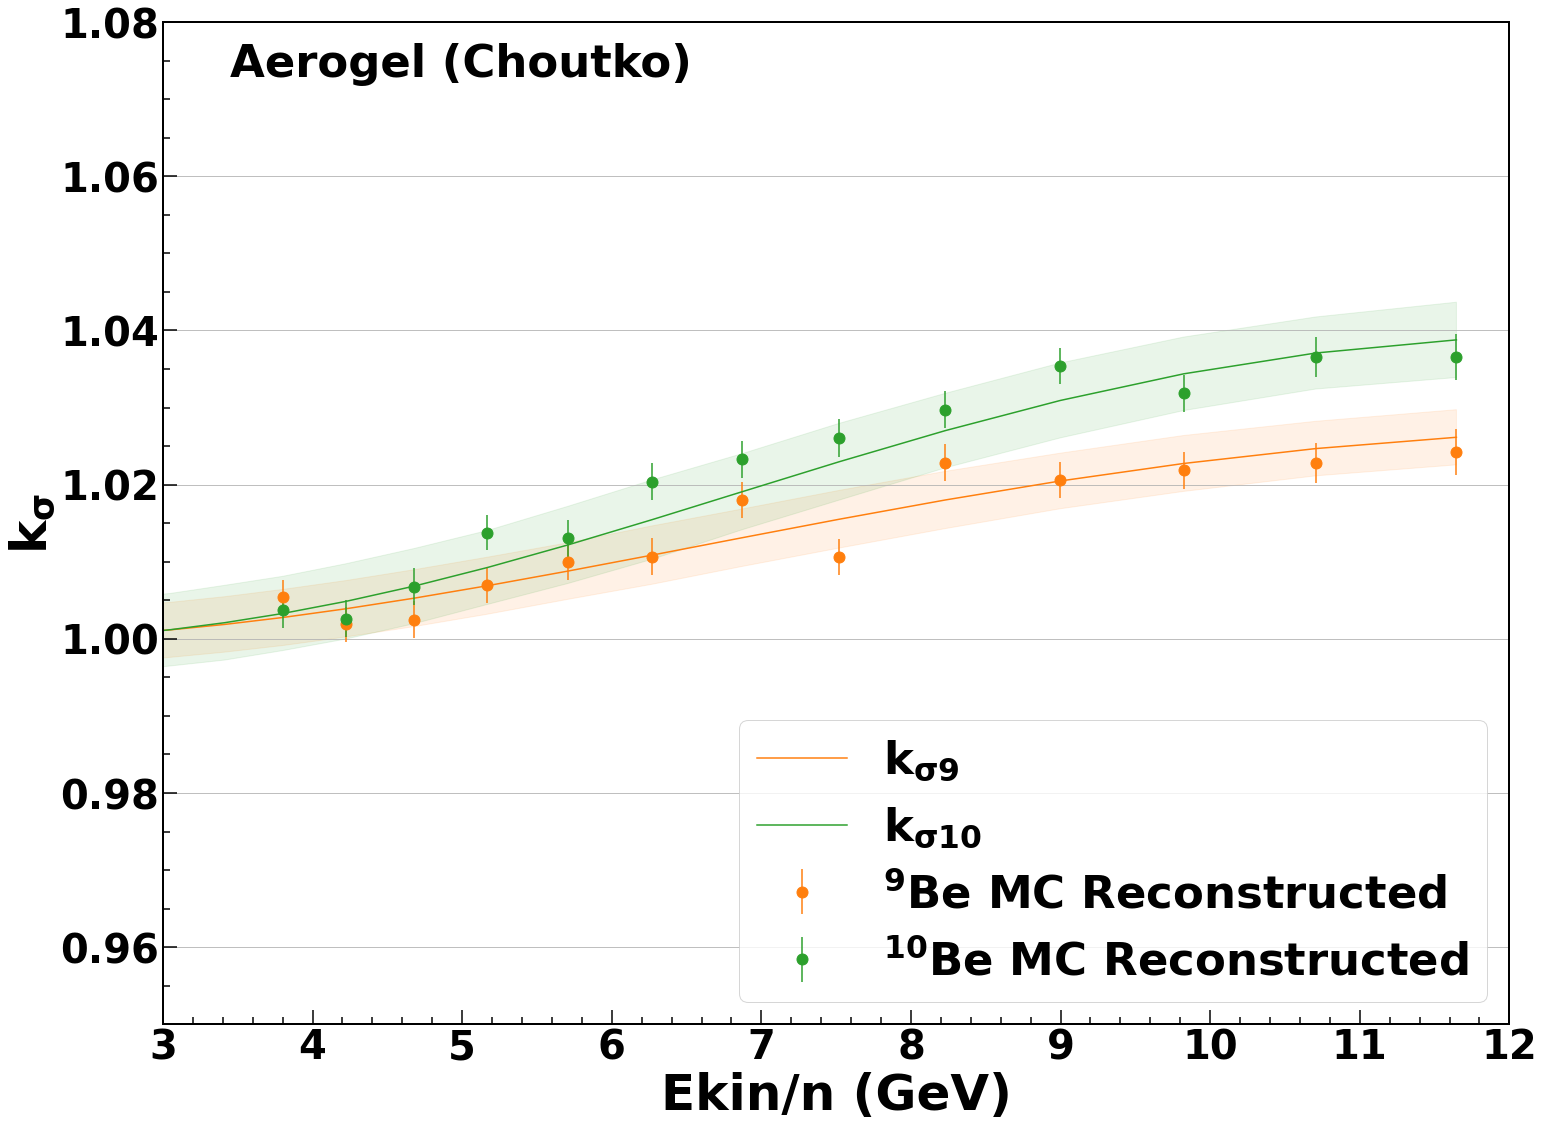

In [49]:
fig, ax1 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 


graph_ratiobe9_Agl = scale_graph(mass_reso_ratio9_Agl, 1)
graph_ratiobe10_Agl = scale_graph(mass_reso_ratio10_Agl, 1)
graph_mass_sigma_9to7_aglcorr  = scale_graph(graph_mass_sigma_9to7['Agl'], ISOTOPES_MASS['Be9']/ ISOTOPES_MASS['Be7'])
graph_mass_sigma_10to7_aglcorr  = scale_graph(graph_mass_sigma_10to7['Agl'], ISOTOPES_MASS['Be10']/ ISOTOPES_MASS['Be7'])
plot_graph(fig, ax1, graph_ratiobe9_Agl, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{k_{\sigma 9}}$')  
plot_graph(fig, ax1, graph_mass_sigma_9to7_aglcorr, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{{^9{{Be}} }}$ MC Reconstructed')  
print(graph_mass_sigma_9to7['Agl'])
plot_graph(fig, ax1, graph_ratiobe10_Agl, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{k_{\sigma 10}}$')  
plot_graph(fig, ax1, graph_mass_sigma_10to7_aglcorr, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{{^{{10}}{{Be}} }}$ MC Reconstructed') 
print(graph_mass_sigma_9to7['Agl']) 
yratio_low_Agl = graph_ratiobe9_Agl.yvalues - graph_ratiobe9_Agl.yerrs
yratio_up_Agl = graph_ratiobe9_Agl.yvalues + graph_ratiobe9_Agl.yerrs
ax1.fill_between(graph_ratiobe9_Agl.xvalues, yratio_low_Agl, yratio_up_Agl, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_Agl10 = graph_ratiobe10_Agl.yvalues - graph_ratiobe10_Agl.yerrs
yratio_up_Agl10 = graph_ratiobe10_Agl.yvalues + graph_ratiobe10_Agl.yerrs
ax1.fill_between(graph_ratiobe10_Agl.xvalues, yratio_low_Agl10, yratio_up_Agl10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  
ax1.set_xlim([3.0, 12.0])
ax1.set_ylim([0.95, 1.08])
ax1.grid(axis='y')                                         
ax1.set_xlabel('Ekin/n (GeV)', fontsize=50) 
ax1.legend(loc="lower right", fontsize=45) 
#ax1.set_xscale('log')
ax1.set_ylabel(r'$\mathrm{k_{\sigma}}$', fontsize=50)
#ax1.set_xticklabels([3.0, 4.0, 6.0, 10.0])
set_plot_defaultstyle(ax1)
#ax1.set_xticks([3, 4, 10]) 
ax1.text(0.05, 0.98, "Aerogel (Choutko)", fontsize=45, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")

savefig_tofile(fig, plotdir, f"sigma_korrfactor_agl_be9ChoutkoP7", show=True)

[ 9.99670896e-01 -1.59133787e-03  5.49441353e-04  1.94904494e-03]
[0.99994634 1.00033238 1.00039883 1.00027381 1.0000486  0.999788
 0.9993589  0.99925612 0.9992583  0.99938113 0.99963887 1.00004024
 1.00058873 1.00129007 1.00215003 1.00316639 1.00434254 1.00568174
 1.00717801 1.00885967 1.01066564 1.01258611 1.01470379 1.01701033
 1.01949565 1.02214873 1.0249583  1.02791289]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.00215003 1.00316639 1.00434254 1.00568174
 1.00717801 1.00885967 1.01066564 1.01258611 1.01470379 1.01701033
 1.01949565 1.02214873 1.0249583  1.02791289]
[ 9.98121934e-01 -3.84696841e-03  5.28288236e-03 -3.68307467e-05
  6.05422363e-04]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.00266583 1.00424213 1.00603623 1.00805735
 1.01030177 1.01281794 1.01552101 1.01840276 1.02159413 

FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410/mass_sigmap_isoratio.png'

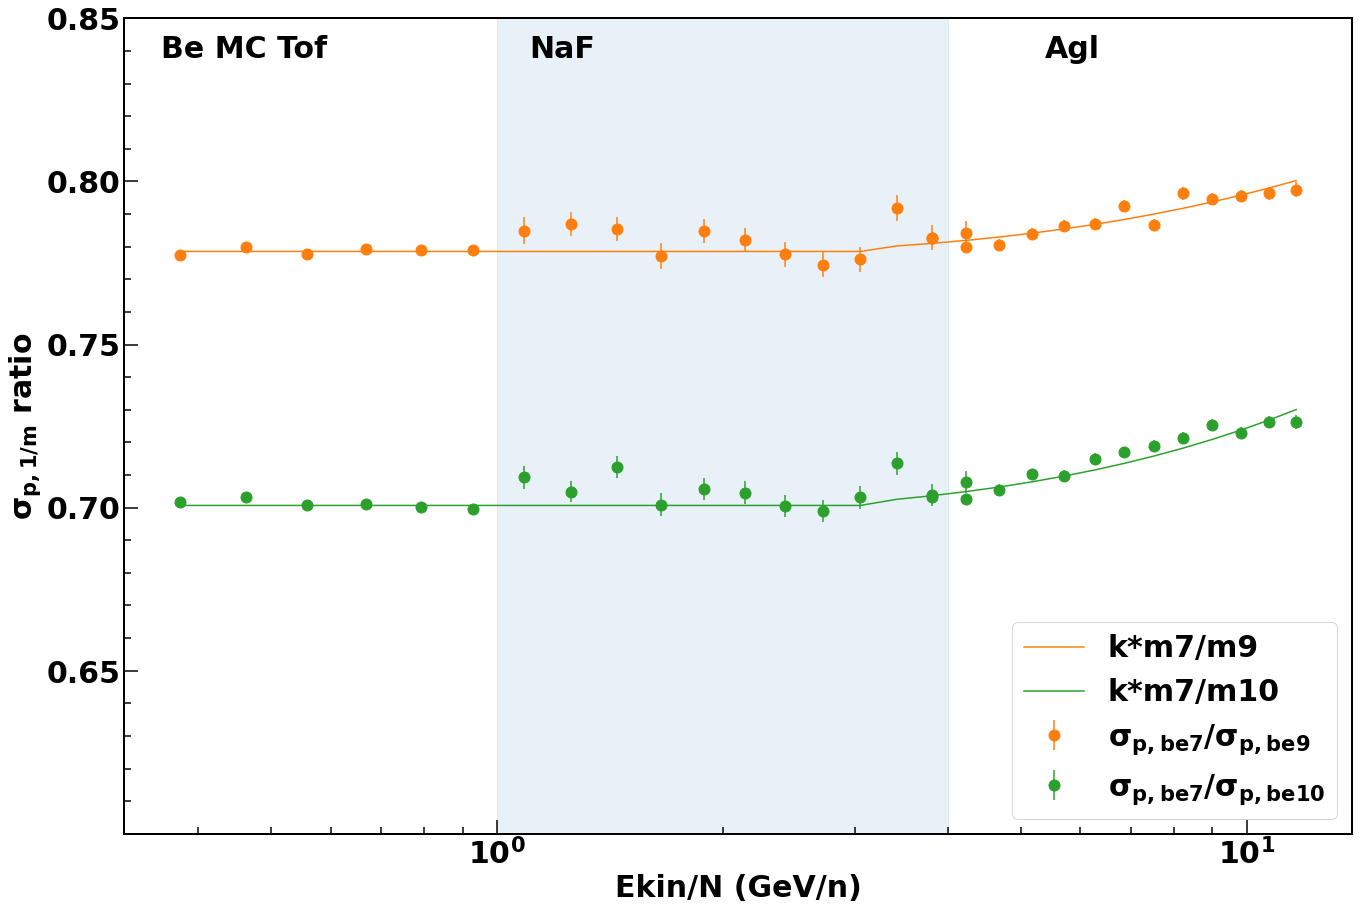

In [49]:
from tools.graphs import scale_graph
#filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitAll/df_sigma_ratio_sigma.npz'
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23/df_ratio_sigma_iter2.npz'
filename11 = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v11/df_ratio_sigma_iter2.npz'

df_sigma_ratio = np.load(f'{filename}')
df_sigma_ratio11 = np.load(f'{filename11}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
for dec in detectors:
    if dec == 'Tof':
        graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio11, f"graph_mass_sigma_9to7_{dec}")
        graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio11, f"graph_mass_sigma_10to7_{dec}")
    else:
        graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_9to7_{dec}")
        graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_10to7_{dec}")
        
        

#graph_mass_sigma_9to7['NaF'] = scale_graph(graph_mass_sigma_9to7['NaF'], 0.998)
#graph_mass_sigma_9to7['Agl'] = scale_graph(graph_mass_sigma_9to7['Agl'], 0.998)
#graph_mass_sigma_10to7['NaF'] = scale_graph(graph_mass_sigma_10to7['NaF'], 0.999)
#graph_mass_sigma_10to7['Agl'] = scale_graph(graph_mass_sigma_10to7['Agl'], 0.999)      
from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
fig, ax1 = plt.subplots(1, 1, figsize= figSize)
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
for dec in detectors: 
    if dec =="Tof":
        plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\sigma_{p,be7}/\sigma_{p, be9}}$")
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label="$\mathrm{\sigma_{p,be7}/\sigma_{p, be10}}$")
        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    else:                                                                                                            
        plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")       
ax1.set_ylim([0.6, 0.85])
                                                                                                                                                                        
#ax2.legend(fontsize=20)                                                                                                                                                                          
                                                                                                                                                                        
ax2.grid()                                                                                                                                                                                       
set_plot_defaultstyle(ax1)                                                                                                                                                                       
set_plot_defaultstyle(ax2)                                                                                                                                                                       
ax1.get_yticklabels()[0].set_visible(False)                                                                                                                                                      
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax2.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.6, 0.9, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 

#ax1.plot(sub_mass_reso_ratio9_Tof.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_Tof.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio9_NaF.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_NaF.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio9_Agl.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_Agl.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio10_Tof.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_Tof.yvalues, "-", color='tab:green')
#ax1.plot(sub_mass_reso_ratio10_NaF.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_NaF.yvalues, "-", color='tab:green')
#ax1.plot(sub_mass_reso_ratio10_Agl.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_Agl.yvalues, "-", color='tab:green')

graphratio9 = concatenate_graphs(slice_graph_by_value(sub_mass_reso_ratio9_Tof, [0.3, 1.0]), slice_graph_by_value(sub_mass_reso_ratio9_NaF, [1.2, 3.0]))
graphratio9 = concatenate_graphs(graphratio9, slice_graph_by_value(sub_mass_reso_ratio9_Agl, [3.0, 12]))
popt9, pcov9 = curve_fit(poly, np.log(graphratio9.xvalues), graphratio9.yvalues, p0 = [1.0, 1.0, 1.0, 1.0])
print(popt9)

yfit_ratiobe9 = poly(np.log(graphratio9.xvalues), *popt9)
print(yfit_ratiobe9)
yfit_ratiobe9[0:14] = 1.0
print(yfit_ratiobe9)
ax1.plot(graphratio9.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'] * yfit_ratiobe9, "-", color='tab:orange', label='k*m7/m9')
#ax1.plot(graphratio9.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'] * graphratio9.yvalues, "-", color='tab:orange', label='k*m7/m9')
                                 
graphratio10 = concatenate_graphs(slice_graph_by_value(sub_mass_reso_ratio10_Tof, [0.3, 1.0]), slice_graph_by_value(sub_mass_reso_ratio10_NaF, [1.2, 3.0]))
graphratio10 = concatenate_graphs(graphratio10, slice_graph_by_value(sub_mass_reso_ratio10_Agl, [3.0, 12]))

popt10, pcov10 = curve_fit(poly, np.log(graphratio10.xvalues), graphratio10.yvalues, p0 = [1.0, 1.0, 1.0, 1.0, 1.0])
print(popt10)
yfit_ratiobe10 = poly(np.log(graphratio10.xvalues), *popt10)
yfit_ratiobe10[0:14] = 1.0
print(yfit_ratiobe10)

ax1.plot(graphratio10.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'] * yfit_ratiobe10, "-", color=ISOTOPES_COLOR['Be10'], label='k*m7/m10')
#ax1.plot(graphratio10.xvalues, 7.0/10.0 *  graphratio10.yvalues, "-", color='tab:green', label='k*m7/m10')
                                 
#ax1.axhline(y=7.0/9.0, color='orange', linestyle='--')  
#ax1.axhline(y=7.0/10.0, color='green', linestyle='--')  
#label_ref9 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be9'], label='m7/m9')  
#label_ref10 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be10'], label='m7/m10') 
#legend2 = ax1.legend(handles=[label_ref9, label_ref10], loc='upper left', bbox_to_anchor=(0.05, 0.2), fontsize=20)   
#ax1.add_artist(legend2)  
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)
print(plotdir)
savefig_tofile(fig, plotdir, 'mass_sigmap_isoratio', 1)


[ 9.99670896e-01 -1.59133787e-03  5.49441353e-04  1.94904494e-03]
[0.99994634 1.00033238 1.00039883 1.00027381 1.0000486  0.999788
 0.9993589  0.99925612 0.9992583  0.99938113 0.99963887 1.00004024
 1.00058873 1.00129007 1.00215003 1.00316639 1.00434254 1.00568174
 1.00717801 1.00885967 1.01066564 1.01258611 1.01470379 1.01701033
 1.01949565 1.02214873 1.0249583  1.02791289]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.00129007 1.00215003 1.00316639 1.00434254 1.00568174
 1.00717801 1.00885967 1.01066564 1.01258611 1.01470379 1.01701033
 1.01949565 1.02214873 1.0249583  1.02791289]
[ 9.98121934e-01 -3.84696841e-03  5.28288236e-03 -3.68307467e-05
  6.05422363e-04]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.00129909 1.00266583 1.00424213 1.00603623 1.00805735
 1.01030177 1.01281794 1.01552101 1.01840276 1.02159413 

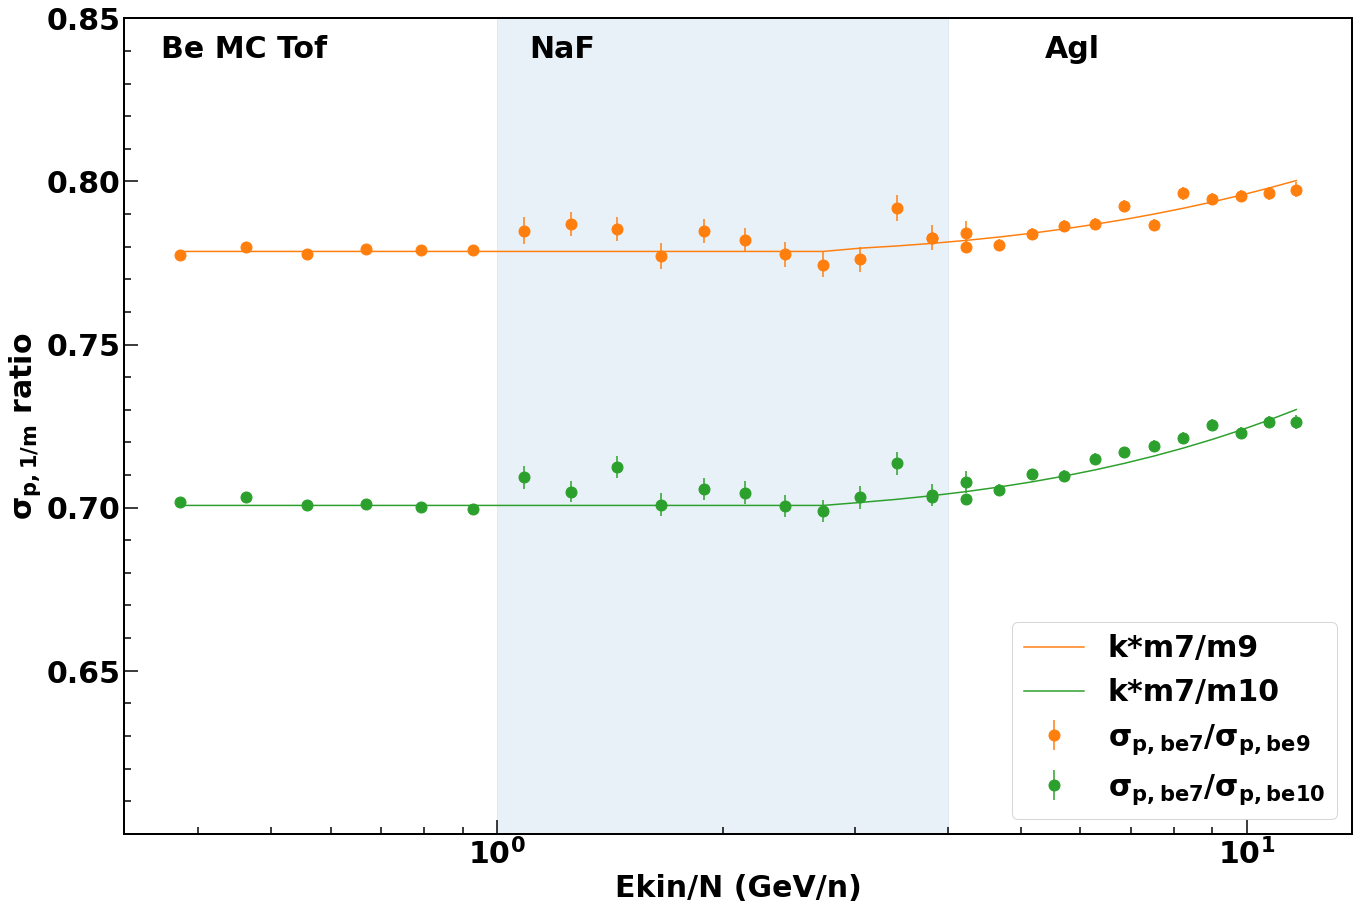

In [43]:
from tools.graphs import scale_graph
#filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitAll/df_sigma_ratio_sigma.npz'
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23/df_ratio_sigma_iter2.npz'
filename11 = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v11/df_ratio_sigma_iter2.npz'

df_sigma_ratio = np.load(f'{filename}')
df_sigma_ratio11 = np.load(f'{filename11}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
for dec in detectors:
    if dec == 'Tof':
        graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio11, f"graph_mass_sigma_9to7_{dec}")
        graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio11, f"graph_mass_sigma_10to7_{dec}")
    else:
        graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_9to7_{dec}")
        graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_10to7_{dec}")
        
        

#graph_mass_sigma_9to7['NaF'] = scale_graph(graph_mass_sigma_9to7['NaF'], 0.998)
#graph_mass_sigma_9to7['Agl'] = scale_graph(graph_mass_sigma_9to7['Agl'], 0.998)
#graph_mass_sigma_10to7['NaF'] = scale_graph(graph_mass_sigma_10to7['NaF'], 0.999)
#graph_mass_sigma_10to7['Agl'] = scale_graph(graph_mass_sigma_10to7['Agl'], 0.999)      
from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
fig, ax1 = plt.subplots(1, 1, figsize= figSize)
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
for dec in detectors: 
    if dec =="Tof":
        plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\sigma_{p,be7}/\sigma_{p, be9}}$")
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label="$\mathrm{\sigma_{p,be7}/\sigma_{p, be10}}$")
        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    else:                                                                                                            
        plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")       
ax1.set_ylim([0.6, 0.85])
                                                                                                                                                                        
#ax2.legend(fontsize=20)                                                                                                                                                                          
                                                                                                                                                                        
ax2.grid()                                                                                                                                                                                       
set_plot_defaultstyle(ax1)                                                                                                                                                                       
set_plot_defaultstyle(ax2)                                                                                                                                                                       
ax1.get_yticklabels()[0].set_visible(False)                                                                                                                                                      
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax2.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.6, 0.9, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 

#ax1.plot(sub_mass_reso_ratio9_Tof.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_Tof.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio9_NaF.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_NaF.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio9_Agl.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_Agl.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio10_Tof.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_Tof.yvalues, "-", color='tab:green')
#ax1.plot(sub_mass_reso_ratio10_NaF.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_NaF.yvalues, "-", color='tab:green')
#ax1.plot(sub_mass_reso_ratio10_Agl.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_Agl.yvalues, "-", color='tab:green')

graphratio9 = concatenate_graphs(slice_graph_by_value(sub_mass_reso_ratio9_Tof, [0.3, 1.0]), slice_graph_by_value(sub_mass_reso_ratio9_NaF, [1.2, 3.0]))
graphratio9 = concatenate_graphs(graphratio9, slice_graph_by_value(sub_mass_reso_ratio9_Agl, [3.0, 12]))
popt9, pcov9 = curve_fit(poly, np.log(graphratio9.xvalues), graphratio9.yvalues, p0 = [1.0, 1.0, 1.0, 1.0])
print(popt9)

yfit_ratiobe9 = poly(np.log(graphratio9.xvalues), *popt9)
print(yfit_ratiobe9)
yfit_ratiobe9[0:13] = 1.0
print(yfit_ratiobe9)
ax1.plot(graphratio9.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'] * yfit_ratiobe9, "-", color='tab:orange', label='k*m7/m9')
#ax1.plot(graphratio9.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'] * graphratio9.yvalues, "-", color='tab:orange', label='k*m7/m9')
                                 
graphratio10 = concatenate_graphs(slice_graph_by_value(sub_mass_reso_ratio10_Tof, [0.3, 1.0]), slice_graph_by_value(sub_mass_reso_ratio10_NaF, [1.2, 3.0]))
graphratio10 = concatenate_graphs(graphratio10, slice_graph_by_value(sub_mass_reso_ratio10_Agl, [3.0, 12]))

popt10, pcov10 = curve_fit(poly, np.log(graphratio10.xvalues), graphratio10.yvalues, p0 = [1.0, 1.0, 1.0, 1.0, 1.0])
print(popt10)
yfit_ratiobe10 = poly(np.log(graphratio10.xvalues), *popt10)
yfit_ratiobe10[0:13] = 1.0
print(yfit_ratiobe10)

ax1.plot(graphratio10.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'] * yfit_ratiobe10, "-", color=ISOTOPES_COLOR['Be10'], label='k*m7/m10')
#ax1.plot(graphratio10.xvalues, 7.0/10.0 *  graphratio10.yvalues, "-", color='tab:green', label='k*m7/m10')
                                 
#ax1.axhline(y=7.0/9.0, color='orange', linestyle='--')  
#ax1.axhline(y=7.0/10.0, color='green', linestyle='--')  
#label_ref9 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be9'], label='m7/m9')  
#label_ref10 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be10'], label='m7/m10') 
#legend2 = ax1.legend(handles=[label_ref9, label_ref10], loc='upper left', bbox_to_anchor=(0.05, 0.2), fontsize=20)   
#ax1.add_artist(legend2)  
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)
print(plotdir)
savefig_tofile(fig, plotdir, 'mass_sigmap_isoratio', 1)


In [45]:
with open('/home/manbing/Documents/lithiumanalysis/scripts/plots/rigfit_17/spline.pkl', 'rb') as f:
    spline_loaded = pickle.load(f)

#xvalues = np.array([0.37825, 0.4631, 0.559, 0.66835, 0.79125, 0.9303, 1.08555, 1.2571, 1.44745, 1.6566,  1.8872, 2.1419,  2.42075, 2.7237,  3.05343.4126,  3.80125, 4.2221,  4.67795, 5.16875, 5.70575, 6.27195, 6.8673, 7.52005, 8.2303, 8.99805, 9.82325])
xvalues = get_bin_center(fbinning_energy())
sp_kcorr9 = spline_loaded['spline9']
sp_kcorr10 = spline_loaded['spline10']
expected9 = sp_kcorr9(np.log(xvalues)) * 7.0/9.0
expected10 = sp_kcorr10(np.log(xvalues)) *7.0/10
#ax1.plot(xvalues, expected9, "-", color=ISOTOPES_COLOR['Be9'], label="ref k*m7/m9")
#ax1.plot(xvalues, expected10, "-", color=ISOTOPES_COLOR['Be10'], label='ref k*m7/m9')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=25)